## Table of contents :
* [I - Preprocessing](#first)
    * [1 - Feature Selection ](#first_1)
    * [2 - Split training set & testing set](#first_2)
    * [3 - Feature Scaling (standardize data)](#first_3)
* [II - Dummies regressions](#second)
    * [1 - Dummy regression ( target : 'SiteEnergyUse(kBtu)' ) ](#second_1)
    * [2 - Dummy regression ( target : 'TotalGHGEmissions' ) ](#second_2)
* [III - Modelize](#third)
    * [1 - Linear model : ElasticNet](#third_1)
        * [1.1 - ElasticNet (target : 'SiteEnergyUse(kBtu)' )](#enet_1_1)
        * [1.2 - ElasticNet (target : 'TotalGHGEmissions' )](#enet_1_2)
    * [2 - Ensemble methods : Random forest, XGBoost](#third_2)
        * [1.1 - Random forest (target : 'SiteEnergyUse(kBtu)' )](#rfr_1_1)
        * [1.2 - Random forest (target : 'TotalGHGEmissions' )](#rfr_1_2)
        * [2.1 - XGBoost (target : 'SiteEnergyUse(kBtu)' )](#xgb_2_1)
        * [2.2 - XGBoost (target : 'TotalGHGEmissions' )](#xgb_2_2)
    * [3 - Feature Selection : union of the variables selected by the models](#third_3)
    * [4 - Non linear models : Kernel SVR, MLPR](#third_4)
        * [1.1 - Kernel SVR (target : 'SiteEnergyUse(kBtu)' )](#ksvr_1_1)
        * [1.2 - Kernel SVR (target : 'TotalGHGEmissions' )](#ksvr_1_2)
        * [2.1 - MLPR (target : 'SiteEnergyUse(kBtu)' )](#mlpr_2_1)
        * [2.2 - MLPR (target : 'TotalGHGEmissions' )](#mlpr_2_2)
    * [5 - Third training cycle with models union features : Random forest, XGBoost](#third_5)
        * [1.1 - Random forest (target : 'SiteEnergyUse(kBtu)' )](#rfr_1_1_1)
        * [1.2 - Random forest (target : 'TotalGHGEmissions' )](#rfr_1_1_2)
        * [2.1 - XGBoost (target : 'SiteEnergyUse(kBtu)' )](#xgb_2_1_1)
        * [2.2 - XGBoost (target : 'TotalGHGEmissions' )](#xgb_2_1_2)
* [IV - Results](#fourth)
    * [1 - Training results](#fourth_1)
        * [1.1 - Training results (target : 'SiteEnergyUse(kBtu)')](#fourth_1_1)
        * [1.2 - Training results (target : 'TotalGHGEmissions')](#fourth_1_2)
        * [1.3 - Save results data](#fourth_1_3)
    * [2 - Data acquisition : best selected features](#fourth_2)
        * [2.1 - Selected features (target : 'SiteEnergyUse(kBtu)')](#fourth_2_1)
        * [2.2 - Selected features ( target : 'TotalGHGEmissions' )](#fourth_2_2)


In [1]:
# Import custom packages & modules
import sys
sys.path.append("..")
# Univariate analysis module
from src.analyzer.univariate import *
# Multivariate analysis module
from src.analyzer.multivariate import *
# Data cleaning module
from src.datacleaner import *
# Data preprocessing module
from src.preprocessor import *
# Model evaluation module
from src.evaluator import *
# Ensemble-based methods visualization module
from src.modelizer.ensemble.tree_interpreter import *
# Model selection
from sklearn.model_selection import train_test_split
# Linear models
from sklearn.linear_model import ElasticNet, ElasticNetCV
# Non-linear models
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
# Ensemble-based methods
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
# Compute training time
import datetime

In [2]:
# Model evaluation wrappers

# Define project scorers (RMSE & R2)
third_project_scorers = ['neg_root_mean_squared_error', 'r2']

# Main training wrapper using GridSearchCV 
def train_gridsearch(data, model, param_grid, metric=third_project_scorers, k=10, p=3, v=True):
    # Model name
    model_label = model_name(model)
    # Get training & testing data
    x_train, y_train = data['train']
    x_test, y_test = data['test']
    # Define refit condition (first metric if evaluationg multiple metrics else False)
    refit_cond = metric[0] if type(metric) is list else False
    # Build grid search
    gridsearch = GridSearchCV(model, param_grid, cv=k, scoring=metric, refit=refit_cond)
    # Time the model training
    start_training = datetime.datetime.now()
    # Train model with grid search
    gridsearch.fit(x_train, y_train)
    end_training = datetime.datetime.now()
    # Compute training time
    training_time = end_training - start_training
    # Format training time
    training_time_str = format_run_time(training_time)
    # Trained_model
    trained_model = gridsearch.best_estimator_
    # Get scores from cross validation
    cv_scores = {}
    for scorer_label in (metric if type(metric) is list else [metric]):
        if scorer_label.startswith('neg'):
            formatted_label = "".join([w[0] for w in scorer_label.replace('neg_', '').split('_')])
            formatted_score = round(np.abs(gridsearch.cv_results_[f'mean_test_{scorer_label}'])[0], p)
            cv_scores[formatted_label] = formatted_score
        else:
            cv_scores[scorer_label] = round(gridsearch.cv_results_[f'mean_test_{scorer_label}'][0], p)
    # Get scores from testing set
    testing_set_scores = get_model_scores(trained_model, x_test, y_test, list(cv_scores.keys()), p, v)
    # Display cross validation mean scores
    if v:
        print_score_results(cv_scores, set_type='train')
    # Build model dictionary which contains GridSearchCV & model instances (with model name)
    model_data = {'gs': gridsearch,                                 # GridSearchCV trained instance
                  'model': trained_model,                           # Model trained instance
                  'model_name': model_label}                        # Model name
    # Build additional evaluation data dictionary
    additional_evaluation_data = {'time': training_time_str,        # Training time
                                  'n_features': x_train.shape[1],   # Selected features
                                  'learning_potential': None}       # Learning potential
    # Build results dictionary (merge dictionnaries)
    results = dict(**model_data, **testing_set_scores, **additional_evaluation_data)
    return results


def select_most_important_features(features_coefs_df,
                                   n=None,
                                   method='cumsum',
                                   model=None,
                                   thr='mean',
                                   q_value=0.5,
                                   thr_value=None,
                                   v=False):
    """
    Wrapper which select most important features from machine learning model, based on specified method
    (cumulative threshold or)
    """
    # Feature importance selection method
    if method is 'cumsum':                                # if thr is 'cumsum'
        n_mif_data = features_coefs_df.iloc[:n]
        n_mif_labels = n_mif_data['feature'].tolist()
    elif method is 'threshold':                           # else
        # Threshold method
        if thr is 'q': # quantile
            mif_thr = features_coefs_df['coefficient'].quantile(q=q_value)
        elif thr is 'mean': # mean
            mif_thr = features_coefs_df['coefficient'].mean()
        else: # arbitrary number
            mif_thr = thr_value
        # N.B : function from mlearn preprocessor module
        n_mif_data = filter_features_by_threshold(X,
                                                  X_train_std,
                                                  X_test_std,
                                                  model,
                                                  mif_thr,
                                                  verbose=v)
        n_mif_labels = n_mif_data['labels']
    # Return n selected features dataframe & labels
    return n_mif_data, n_mif_labels


def run_training_cycle(features_reduced,
                       model_param_grid,
                       model=None,
                       target='energy',
                       training_wrapper='gs',
                       k=5,
                       s=third_project_scorers,
                       p=3,
                       v=True):
    """
    Wrapper which run a training cycle based on reduced features
    """
    # Filter training and testing features data (reduce the number of features)
    X_train_std_reduced = X_train_std_df.loc[:, features_reduced]
    X_test_std_reduced = X_test_std_df.loc[:, features_reduced]
    # Define target type
    if target is 'energy':
        y_train_target, y_test_target = y_train_energy, y_test_energy
    elif target is 'emissions':
        y_train_target, y_test_target = y_train_emissions, y_test_emissions
    # Build training & testing data dictionary for each target   
    training_and_testing_data_reduced = {"train": [X_train_std_reduced, y_train_target],
                                         "test": [X_test_std_reduced, y_test_target]}
    # Define training wrapper type (elastic net cross val or gridsearchCV)
    if training_wrapper == 'en':
        results = train_elastic_net(training_and_testing_data_reduced,
                                    model_param_grid)
    elif training_wrapper == 'gs':
        results = train_gridsearch(training_and_testing_data_reduced,
                                   model,
                                   model_param_grid,
                                   metric=s,
                                   k=k,       
                                   p=p,
                                   v=v)
    return results, training_and_testing_data_reduced


# Elastic Net Wrapper

def train_elastic_net(data, params_grid, k=10, v=True, s=['rmse', 'r2']):
    # Get training and testing sets from data dictionary
    X_train_std, y_train = data["train"]
    X_test_std, y_test = data["test"]
    # Get (hyper)parameters from parameters grid
    alpha_range, l1_ratio_range = params_grid.values()
    # Build model using cross validation 
    elastic_net = ElasticNetCV(alphas=alpha_range,
                               cv=k,
                               l1_ratio=l1_ratio_range)
    start_training = datetime.datetime.now()
    # Train model with cross validation
    elastic_net.fit(X_train_std, y_train)
    end_training = datetime.datetime.now()
    # Compute training time
    training_time = end_training - start_training
    # Format training time
    training_time_str = format_run_time(training_time)
    # Optimal parameters
    optimal_alpha = elastic_net.alpha_
    optimal_l1_ratio = elastic_net.l1_ratio_
    if v:
        print("Alpha : {} | l1_ratio : {}\n".format(optimal_alpha,
                                                    optimal_l1_ratio))
    # Regularization path
    alphas, coefs, _ = elastic_net.path(X_train_std,
                                        y_train,
                                        alphas=alpha_range,
                                        l1_ratio=optimal_l1_ratio)
    # Format scorer label (example : neg_root_mean_squared_error --> rmse)
    formatted_s = []
    for scorer_label in s:
        if scorer_label.startswith('neg'):
            scorer_label = "".join([w[0] for w in scorer_label.replace('neg_', '').split('_')])
        formatted_s.append(scorer_label)
    # Model evaluation
    testing_set_scores = get_model_scores(elastic_net,
                                          X_test_std,
                                          y_test,
                                          scorer=formatted_s,
                                          verbose=v)
    # Build model dictionary which contains model data (instance & name)
    model_data = {'model': elastic_net,
                  'model_name': model_name(elastic_net)}
    # Build additional evaluation data dictionary
    additional_evaluation_data = {'time': training_time_str,            # Training time
                                  'n_features': X_train_std.shape[1],   # Selected features
                                  'learning_potential': None,           # Learning potential
                                  'best_params': [optimal_alpha, optimal_l1_ratio],
                                  'reg_path_data': [alphas, coefs]}            
    # Build results dictionary (merge dictionnaries) 
    results = dict(**model_data, **testing_set_scores, **additional_evaluation_data)
    return results


In [3]:
# Import du dataset
df_raw = pd.read_csv('../data/csv/seattle_model_data_no_ENERGYSTARScore.csv')
df = df_raw.copy()
print(df.shape)
df.head(2)

(6129, 213)


PropertyGFATotal  LargestPropertyUseTypeGFA  \
0         11.016299                  11.016299   
1         10.654927                  10.396750   

   SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
0                         0.000000                             0.0   
1                         9.174506                             0.0   

   NumberofFloors  SiteEnergyUse(kBtu)  TotalGHGEmissions  OldBuilding  \
0               3            14.494209           3.761898            1   
1               4            13.865236           1.991976            1   

   Main_energy_electricity  Main_energy_gas  ...  Neighborhood_Downtown  \
0                        1                0  ...                      0   
1                        1                0  ...                      0   

   Neighborhood_East  Neighborhood_Greater duwamish  Neighborhood_Lake union  \
0                  0                              0                        0   
1                  0                              0                        0   

   Neighborhood_Magnolia / queen anne  Neighborhood_North  \
0                                   0                   0   
1                                   0                   0   

   Neighborhood_Northeast  Neighborhood_Northwest  Neighborhood_Southeast  \
0                       0                       0                       0   
1                       0                       0                       0   

   Neighborhood_Southwest  
0                       0  
1                       0  

[2 rows x 213 columns]

In [4]:
# Targets
targets_cols = ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']

# Features
features_cols = [col for col in df.columns if col not in targets_cols]

# Features data
df_without_targets = df[features_cols]

# I - Preprocessing <a class="anchor" id="first"></a>

### 1 - Feature Selection  <a class="anchor" id="first_1"></a>

#### 1.1 - Filter features with identical or null variance

In [5]:
# N.B : functions from mlearn prepocessor module 

# Method :
# null_variance_cols = features_with_null_variances(df, verbose=True)
# identical_variance_cols = features_with_identical_variances(df, col_kept='last', verbose=True)
# invalid_variances_cols = null_variance_cols + identical_variance_cols
# df = df[[col for col in df.columns if col not in invalid_variances_cols]]

# Remove invalid features from dataframe
df = filter_invalid_variances(df, feature_kept='last')

0/213 features with null variance, reduction of 0.0%
8/213 features with identical variance, reduction of 3.8%


#### 1.2 - Filter correlated features

In [6]:
# N.B : functions from mlearn prepocessor module 

# Get filtered features dataframe
features = filter_correlated_features(df_without_targets, threshold=0.5, verbose=True)
# features = df_without_targets 

38/211 features correlated, reduction of 18.0%


In [7]:
features.shape

(6129, 173)

### 2 - Split training set & testing set <a class="anchor" id="first_2"></a>

In [8]:
# Features data
X = features

# Extract features labels
training_features = X.columns.tolist()

# Targets data
y = df[targets_cols]

# Training & testing sets split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split targets (energy consumption & gaz emissions features)
y_train_energy, y_train_emissions = [y_train[target] for target in targets_cols]
y_test_energy, y_test_emissions = [y_test[target] for target in targets_cols]

### 3 - Feature Scaling (standardize data) <a class="anchor" id="first_3"></a>

In [9]:
# Standardize data (center & reduce)
# N.B : function from mlearn preprocessor module

X_train_std, std_scaler = standard_scaler(X_train, return_std_scaler=True)
X_test_std = std_scaler.transform(X_test)

# Build training & testing data dictionary for each target
energy_data = {"train": [X_train_std, y_train_energy],
               "test": [X_test_std, y_test_energy]}

emissions_data = {"train": [X_train_std, y_train_emissions],
                  "test": [X_test_std, y_test_emissions]}

In [10]:
# Build dataframes from standardized training & testing data
# => permet de faciliter le filtrage des features qui contribuent le plus au model
X_train_std_df = pd.DataFrame(X_train_std, columns=training_features)
X_test_std_df = pd.DataFrame(X_test_std, columns=training_features)

# II - Dummies regressions : <a class="anchor" id="second"></a>

### 1 - Dummy regression ( target : 'SiteEnergyUse(kBtu)'  ) <a class="anchor" id="second_1"></a>

In [11]:
# Build dummy regression with mean as strategy
y_pred_dum_energy, y_test_dum_energy = dummy_regression(X_train_std,
                                                        y_train_energy,
                                                        X_test_std,
                                                        y_test_energy,
                                                        strategy='mean')

print('Dummy regression : RMSE = {}'.format(mean_squared_error(y_test_energy,
                                                               y_pred_dum_energy,
                                                               squared=False)))

print('Dummy regression : R2 = {}'.format(r2_score(y_test_energy, y_pred_dum_energy)))

Dummy regression : RMSE = 1.1085113481134508
Dummy regression : R2 = -5.508475683124736e-05


### 2 - Dummy regression ( target :  'TotalGHGEmissions' ) <a class="anchor" id="second_2"></a>

In [12]:
y_pred_dum_emissions, y_test_dum_emissions = dummy_regression(X_train_std,
                                                               y_train_emissions,
                                                               X_test_std,
                                                               y_test_emissions,
                                                               strategy='mean')

print('Dummy regression : RMSE = {}'.format(mean_squared_error(y_test_emissions,
                                                               y_pred_dum_emissions,
                                                               squared=False)))

print('Dummy regression : R2 = {}'.format(r2_score(y_test_emissions, y_pred_dum_emissions)))

Dummy regression : RMSE = 1.4624088868366212
Dummy regression : R2 = -8.204599772843046e-05


# III - Modelize : <a class="anchor" id="third"></a>

### Methodology : linear model & ensemble methods :

For each target we carry out the following cycle :
- **Baseline model training** (default (hyper)parameters)
- **Optimization of hyperparameters cyclically** (progressive reduction of the range of values applied to grid search) **with cross validation**
- **Model performance evaluation** (RMSE, R2, run time)
- **Model features contributions evaluation**
- **Feature reduction** : 
    - conversion of negative coefficients into positive coefficients (np.abs())
    - filtering of zero coefficients
    - application of thresholds (modal class, median, third quartile)
- **Second training cycle from reduced features**
- **Best model selection** by a trade-off between total features & score (RMSE, R2))
- **Training & learning curves evaluation**
- **Define model learning potential** from learning curve evaluation ('Yes'/'No')

## 1 - Linear model : ElasticNet <a class="anchor" id="third_1"></a>

#### 1.1 - ElasticNet (target : 'SiteEnergyUse(kBtu)' ) <a class="anchor" id="enet_1_1"></a>

#### 1.1.1 - Train model (optimize hyperparameters)

In [13]:
# alphas range : np.logspace(-3, 3, 10), np.arange(0.001, 0.009, 0.001)
en_params_grid = {"alphas": np.logspace(-3, 3, 10),
                  "l1_ratio": [0.2, 0.4, 0.7, 0.75, 0.8, 0.95, 0.99]}

# Train Elastic Net with cross validation (result is a dictionary)
enet_en_data = train_elastic_net(energy_data, en_params_grid, k=10)

Alpha : 0.004641588833612777 | l1_ratio : 0.99

ElasticNetCV
--------------------------
Testing set performances :
- RMSE = 0.485
- R2 = 0.809


#### 1.1.2 - Regularization path

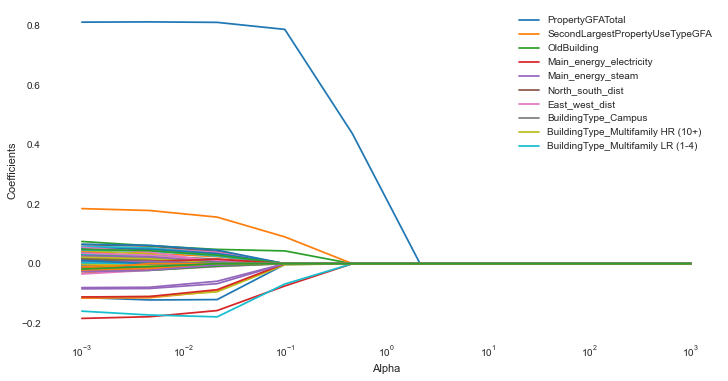

In [14]:
# Get hyperparameter & coefficient ranges
en_alphas, en_coefs = enet_en_data["reg_path_data"]

# N.B : function from mlearn evaluator module
plot_regularization_path(en_alphas, en_coefs.T, training_features, n_features_labels=10)

#### 1.1.3 - Select most important features (method : cumulative feature importance selection)

122/173 features selected, reduction of 29.5%


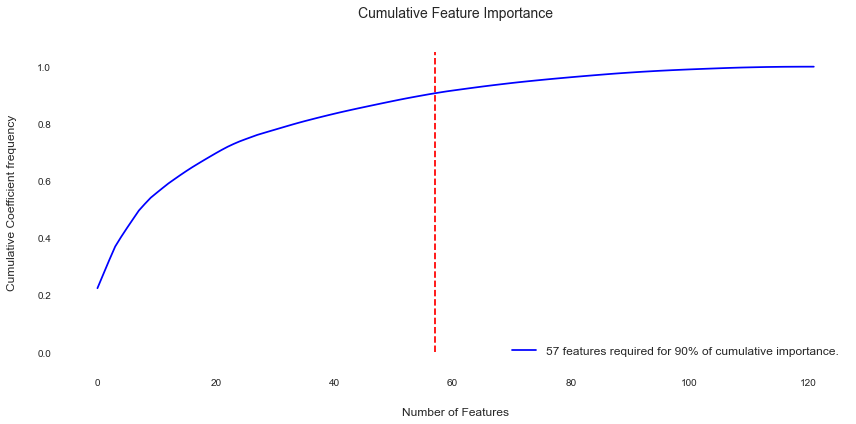

In [15]:
# N.B : Elastic Net reduces the coefficients of irrelevant features to 0. 
# We have therefore selected here features with positive or negative coefficients

elastic_net_en_coefs = enet_en_data["model"].coef_

# Extract feature importance filtered coefficients dataframes
elastic_net_en_features_coefs_df = get_features_importance(training_features,
                                                           elastic_net_en_coefs,
                                                           abs_coefs=True,
                                                           non_zero_coefs=True,
                                                           verbose=True)
# N.B : function from mlearn preprocessor module
plot_cumulative_features_importance(elastic_net_en_features_coefs_df, threshold=0.90, plot_size=(12, 6))

In [16]:
# Select the 64 most important features
enet_en_mif_64_data = elastic_net_en_features_coefs_df.iloc[:64]
enet_en_mif_64_labels = enet_en_mif_64_data['feature'].tolist()

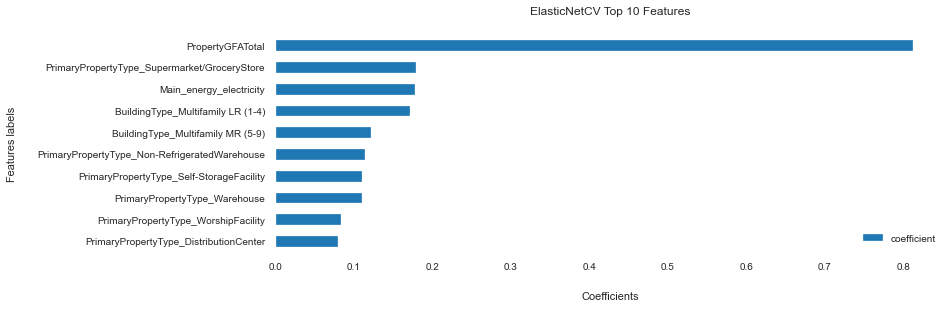

In [17]:
# Visualize n most important features
# N.B : function from mlearn preprocessor module
plot_n_top_features(enet_en_mif_64_data,
                    model_name(enet_en_data["model"]),
                    n=10,
                    plot_size=(12, 4))

#### 1.1.4 - Second training cycle (with cumulative feature importance selection method)

In [18]:
# Second training cycle with features reduced (173 -> 64)

X_train_std_en_64f = X_train_std_df.loc[:, enet_en_mif_64_labels]
X_test_std_en_64f = X_test_std_df.loc[:, enet_en_mif_64_labels]


# Build training & testing data dictionary for each target
en_data_reduced_64f = {"train": [X_train_std_en_64f, y_train_energy],
                       "test": [X_test_std_en_64f, y_test_energy]}


enet_en_reduced_data_64f = train_elastic_net(en_data_reduced_64f, en_params_grid)

Alpha : 0.004641588833612777 | l1_ratio : 0.2

ElasticNetCV
--------------------------
Testing set performances :
- RMSE = 0.487
- R2 = 0.807


#### 1.1.5 - Select most important features (method : threshold feature importance selection)

In [19]:
# We use the same model (from first training cycle)
mif_q3 = elastic_net_en_features_coefs_df['coefficient'].quantile(q=0.75)
ffd = filter_features_by_threshold(X, X_train_std, X_test_std, enet_en_data['model'], mif_q3)
print('Features selected : {}'.format(len(ffd['labels'])))
enet_en_mif_34_labels = ffd['labels']

Features selected : 31


#### 1.1.6 - Second training cycle (with threshold feature selection method)

In [20]:
# Second training cycle with features reduced (173 -> 34)

X_train_std_en_34f = X_train_std_df.loc[:, enet_en_mif_34_labels]
X_test_std_en_34f = X_test_std_df.loc[:, enet_en_mif_34_labels]


# Build training & testing data dictionary for each target
en_data_reduced_34f = {"train": [X_train_std_en_34f, y_train_energy],
                       "test": [X_test_std_en_34f, y_test_energy]}


enet_en_reduced_data_34f = train_elastic_net(en_data_reduced_34f, en_params_grid)
# Cumulative feature importance selection method seems to be slightly better
# (fewer variables selected and a slightly better r2)

Alpha : 0.001 | l1_ratio : 0.2

ElasticNetCV
--------------------------
Testing set performances :
- RMSE = 0.499
- R2 = 0.798


#### 1.1.7 - Training curve

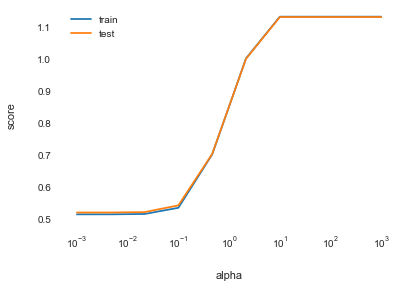

In [21]:
# Plot training curve

# N.B : function from mlearn evaluator module
plot_validation_curve(ElasticNet(alpha=0.001, l1_ratio=0.2),
                      X_train_std_en_34f,
                      y_train_energy,
                      'alpha',
                      np.logspace(-3, 3, 10),
                      log_scale=True,
                      scorer='neg_root_mean_squared_error')

#### 1.1.8 - Learning curve

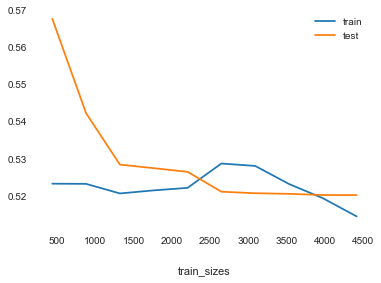

In [22]:
# Plot learning curve

# N.B : function from mlearn evaluator module
plot_learning_curve(ElasticNet(alpha=0.001, l1_ratio=0.2, max_iter=2000),
                    X_train_std_en_34f,
                    y_train_energy,
                    train_sizes_ratio=np.linspace(0.1, 1, 10),
                    scorer='neg_root_mean_squared_error')

# Potential for improvement : No
# Model performance seems to stagnate from around 4 000 observations

In [23]:
enet_en_reduced_data_34f['learning_potential'] = 'No'

#### 1.2 - ElasticNet (target : 'TotalGHGEmissions' ) <a class="anchor" id="enet_1_2"></a>

**N.B** : From here we will use wrappers functions in order to :
 - **select the most important features**
 - **repeat training cycles**

#### 1.2.1 - Train model (optimize hyperparameters)

In [24]:
# Train model
em_params_grid = {"alphas": np.logspace(-3, 3, 10),
                  "l1_ratio": [0.2, 0.4, 0.7, 0.75, 0.8, 0.95, 0.99]}

enet_em_data = train_elastic_net(emissions_data, em_params_grid, k=10)

Alpha : 0.004641588833612777 | l1_ratio : 0.99

ElasticNetCV
--------------------------
Testing set performances :
- RMSE = 0.74
- R2 = 0.744


#### 1.2.2 - Regularization path

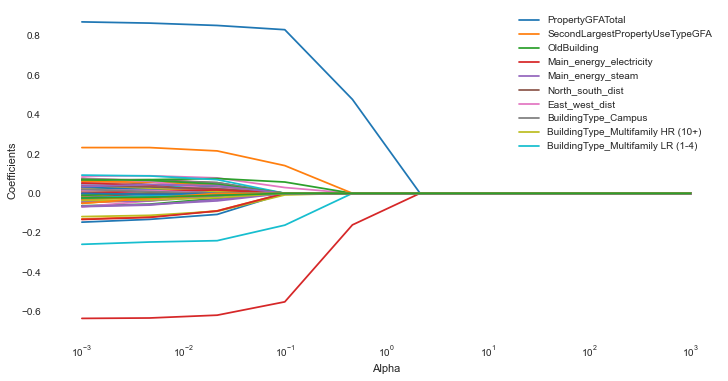

In [25]:
em_alphas, em_coefs = enet_em_data["reg_path_data"]

plot_regularization_path(em_alphas, em_coefs.T, training_features, n_features_labels=10)

#### 1.2.3 - Select most important features (method : cumulative feature importance selection)

132/173 features selected, reduction of 23.7%


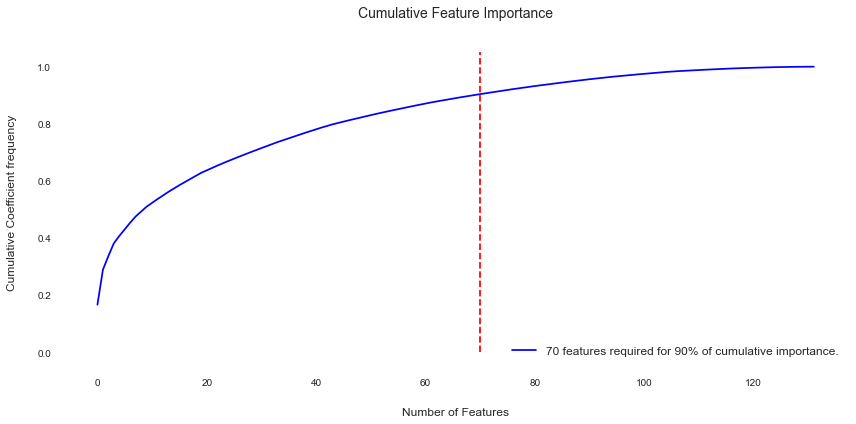

In [26]:
elastic_net_em_coefs = enet_em_data["model"].coef_

elastic_net_em_features_coefs_df = get_features_importance(training_features,
                                                           elastic_net_em_coefs,
                                                           abs_coefs=True,
                                                           non_zero_coefs=True,
                                                           verbose=True)

plot_cumulative_features_importance(elastic_net_em_features_coefs_df, threshold=0.90, plot_size=(12, 6))

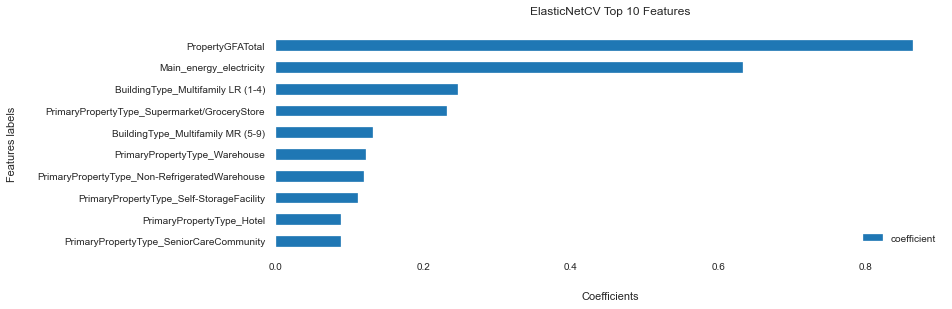

In [27]:
enet_em_mif_69_data, enet_em_mif_69_labels = select_most_important_features(elastic_net_em_features_coefs_df,
                                                                            n=69,
                                                                            method='cumsum')
# Visualize n most important features
plot_n_top_features(enet_em_mif_69_data,
                    model_name(enet_em_data["model"]),
                    n=10,
                    plot_size=(12, 4))

#### 1.2.4 - Second training cycle (with cumulative feature importance selection method)

In [28]:
# Second training cycle with features reduced (173 -> 69)

# em_params_grid = {"alphas": np.arange(0.0020, 0.0030, 0.0001),
#                   "l1_ratio": [0.2, 0.4, 0.7, 0.75, 0.8, 0.95, 0.99]}

enet_em_reduced_data_69f, train_and_test_data_reduced_69f  = run_training_cycle(enet_em_mif_69_labels,
                                                                                em_params_grid,
                                                                                training_wrapper='en') 

Alpha : 0.004641588833612777 | l1_ratio : 0.4

ElasticNetCV
--------------------------
Testing set performances :
- RMSE = 0.494
- R2 = 0.802


#### 1.2.5 - Select most important features (method : threshold feature importance selection)

In [29]:
enet_em_mif_n_data, enet_em_mif_n_labels = select_most_important_features(elastic_net_em_features_coefs_df,
                                                                          method='threshold',
                                                                          model=enet_em_data["model"],
                                                                          thr='q',
                                                                          q_value=0.75, # Q3
                                                                          v=True)
# # Visualize n most important features
# plot_n_top_features(mif_n_data['data'],
#                     model_name(enet_emissions_data["model"]),
#                     n=10,
#                     plot_size=(12, 4))

33/173 selected features, reduction of 19.1%


#### 1.2.6 - Second training cycle (with threshold feature selection method)

In [30]:
# Second training cycle with features reduced (173 -> 35)

enet_em_reduced_data_35f, train_and_test_data_reduced_35f  = run_training_cycle(enet_em_mif_n_labels,
                                                                                em_params_grid,
                                                                                training_wrapper='en') 

Alpha : 0.001 | l1_ratio : 0.2

ElasticNetCV
--------------------------
Testing set performances :
- RMSE = 0.498
- R2 = 0.798


#### 1.2.7 - Training curve

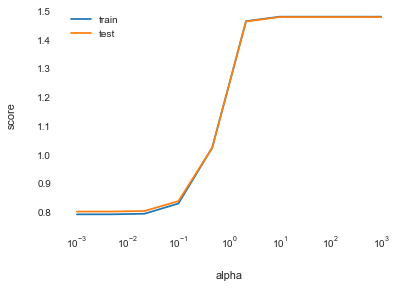

In [31]:
# Plot training curve

x_train_std_em_35f = train_and_test_data_reduced_35f['train'][0]

plot_validation_curve(ElasticNet(alpha=0.001, l1_ratio=0.4),
                      x_train_std_em_35f,
                      y_train_emissions,
                      'alpha',
                      np.logspace(-3, 3, 10),
                      log_scale=True,
                      scorer='neg_root_mean_squared_error')

#### 1.2.8 - Learning curve

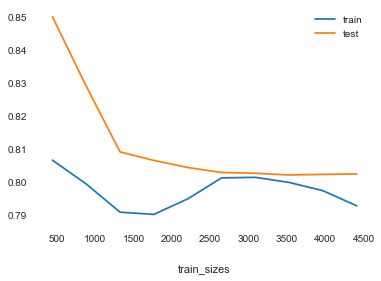

In [32]:
# Plot learning curve

plot_learning_curve(ElasticNet(alpha=0.001, l1_ratio=0.4, max_iter=2000),
                    x_train_std_em_35f,
                    y_train_emissions,
                    train_sizes_ratio=np.linspace(0.1, 1, 10),
                    scorer='neg_root_mean_squared_error')

# Potential for improvement : No
# The curve stagnates around 2500 observations

In [33]:
enet_em_reduced_data_35f['learning_potential'] = 'No'

### 2 - Ensemble methods : Random forest, XGBoost <a class="anchor" id="third_2"></a>

#### 1.1 - Random Forest (target : 'SiteEnergyUse(kBtu)' ) <a class="anchor" id="rfr_1_1"></a>

#### 1.1.1 - Train model (optimize hyperparameters)

In [34]:
%%time 

# Random Forest

rfr_model = RandomForestRegressor(random_state=42)

#    n_estimators range      |       max_depth range
#  np.arange(200, 550, 50)   |      [2, 4, 6, 8, 10]
# [400, 500, 600]

# Optimal hyperparameters
rfr_en_params = {'n_estimators': [500],
#                'max_depth': [40],
#                'max_features': ['auto', 'sqrt', 'log2']
                 'min_samples_leaf': [1]}

rfr_en_data = train_gridsearch(energy_data,
                               rfr_model,
                               rfr_en_params,
                               k=10)

# print(rfr_en_data['model'])
"""
- RMSE = 0.464
- R2 = 0.831
"""

RandomForestRegressor
--------------------------
Testing set performances :
- RMSE = 0.377
- R2 = 0.885
--------------------------------
Training set performances (CV) :
- RMSE = 0.443
- R2 = 0.846
CPU times: user 3min 38s, sys: 826 ms, total: 3min 38s
Wall time: 3min 38s


'\n- RMSE = 0.464\n- R2 = 0.831\n'

#### 1.1.2 - Select most important features (method : cumulative feature importance selection)

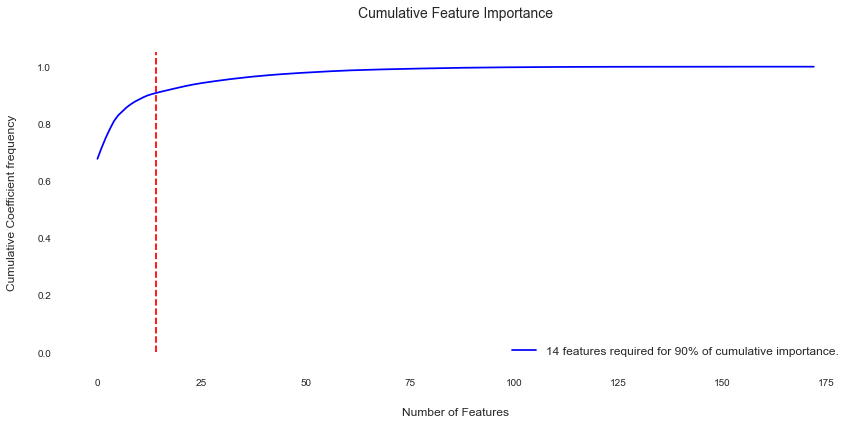

In [35]:
rfr_en_model = rfr_en_data['model']
rfr_en_coefs = rfr_en_model.feature_importances_

rfr_en_features_coefs_df = get_features_importance(training_features,
                                                   rfr_en_coefs,
                                                   abs_coefs=True,
                                                   non_zero_coefs=False,
                                                   verbose=False)

plot_cumulative_features_importance(rfr_en_features_coefs_df, threshold=0.90, plot_size=(12, 6))

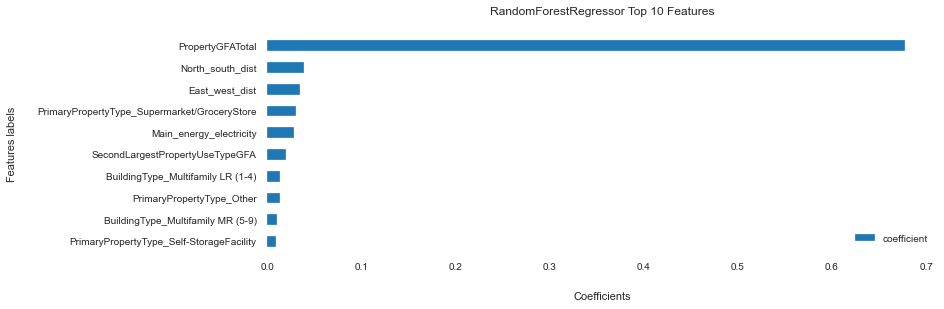

In [36]:
rfr_en_mif_13_data, rfr_en_mif_13_labels = select_most_important_features(rfr_en_features_coefs_df,
                                                                          n=13,
                                                                          method='cumsum')
# Visualize n most important features
plot_n_top_features(rfr_en_mif_13_data,
                    model_name(rfr_en_model),
                    n=10,
                    plot_size=(12, 4))

#### 1.1.3 - Second training cycle (with cumulative feature importance selection method)

In [37]:
# Second training cycle with features reduced (173 -> 13)

rfr_en_model_c2 = RandomForestRegressor(random_state=42)

rfr_en_params = {'n_estimators': [300],
#                'max_depth': [40],
#                'max_features': ['auto', 'sqrt', 'log2']
                 'min_samples_leaf': [1]}

rfr_en_reduced_data_13f, train_and_test_data_reduced_13f  = run_training_cycle(rfr_en_mif_13_labels,
                                                                               rfr_en_params,
                                                                               rfr_en_model_c2) 

RandomForestRegressor
--------------------------
Testing set performances :
- RMSE = 0.392
- R2 = 0.875
--------------------------------
Training set performances (CV) :
- RMSE = 0.478
- R2 = 0.821


#### 1.1.4 - Display random decision tree (from cumulative feature importance selection method)

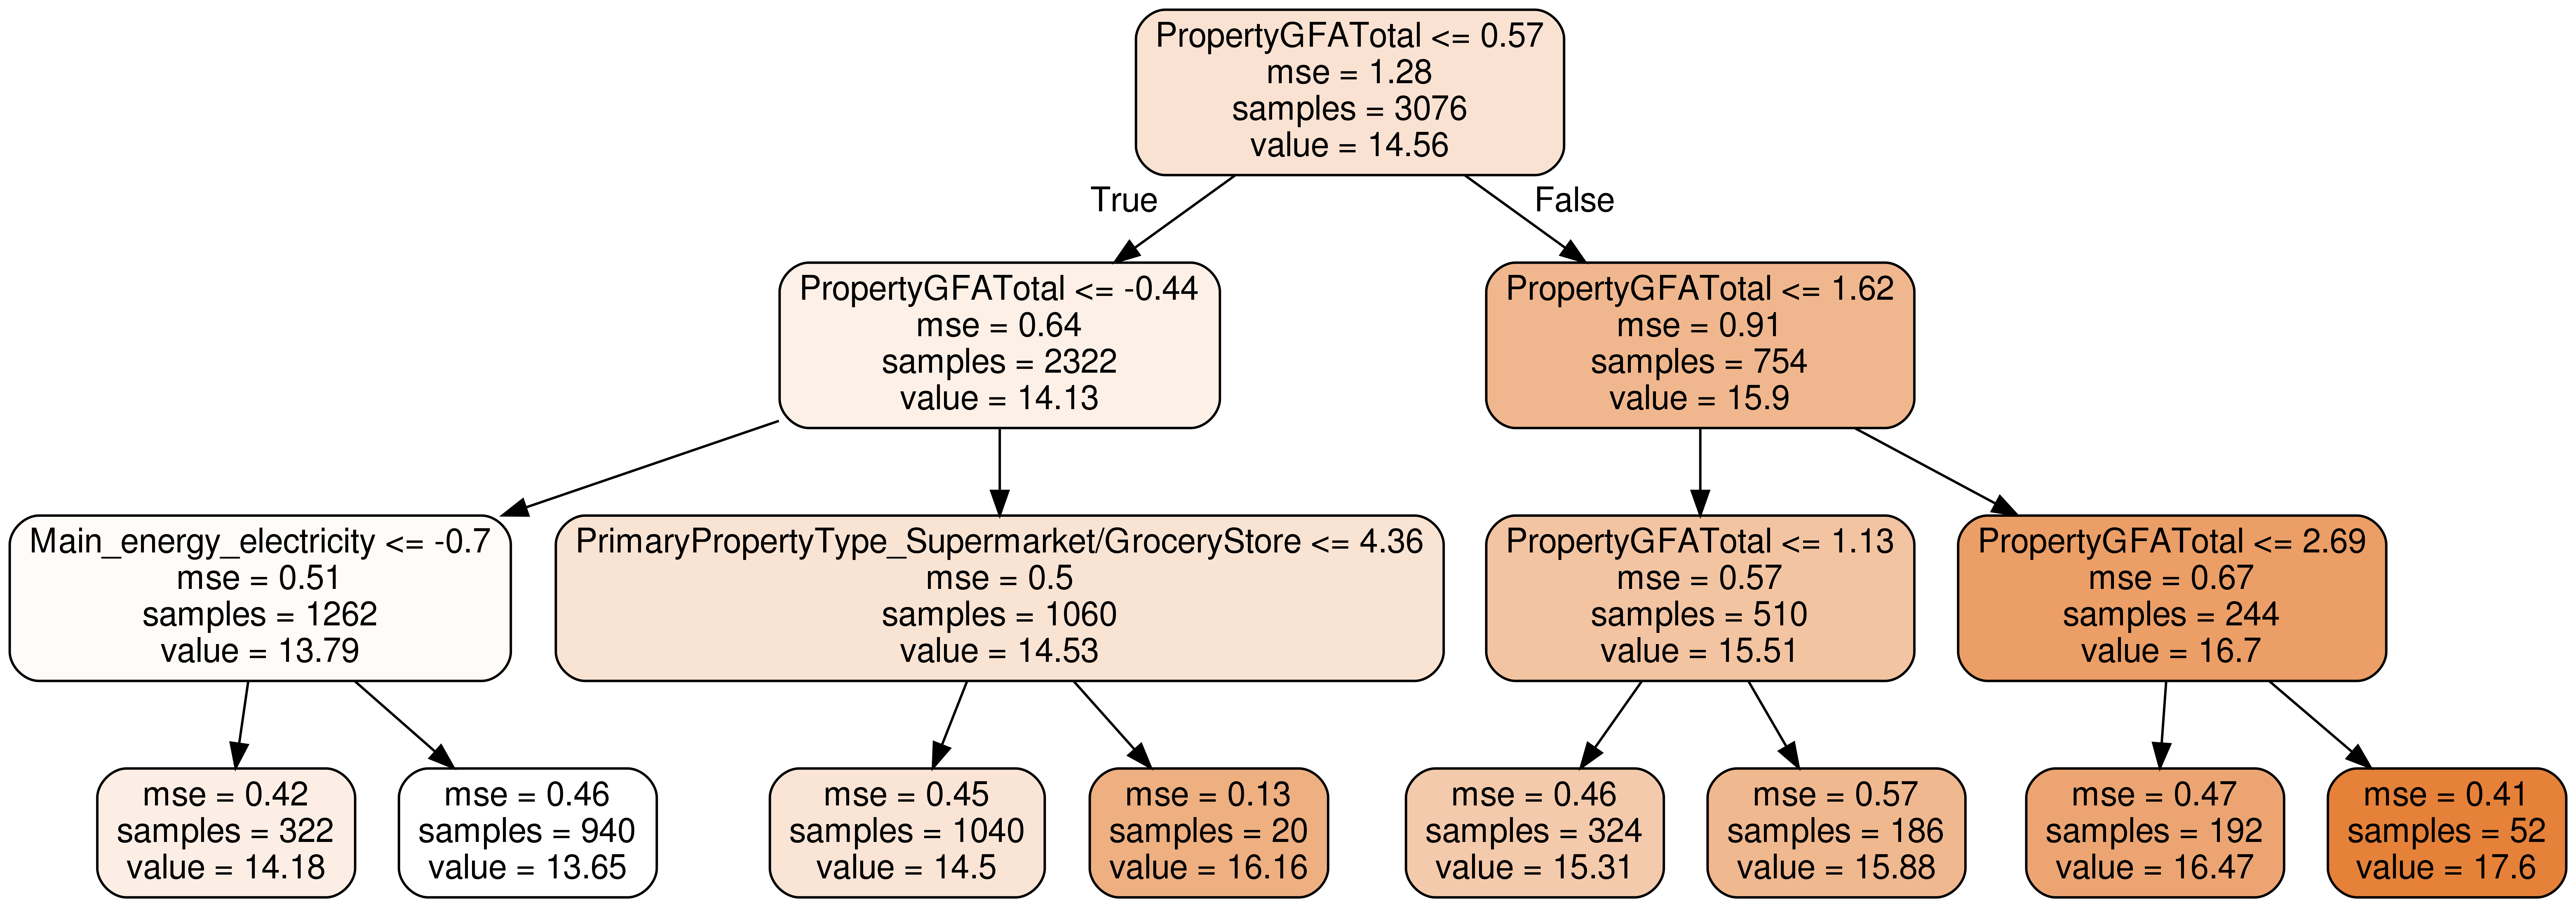

In [38]:
# Display naiv decision tree
rfr_en_naiv_model = RandomForestRegressor(n_estimators=300, random_state=42, max_depth=3)
rfr_en_naiv_model.fit(*train_and_test_data_reduced_13f['train'])

display_decision_tree(rfr_en_naiv_model,
                      rfr_en_mif_13_labels,
                      targets_cols[0],
                      tree_nb=5)

#### 1.1.5 - Select most important features (method : threshold feature importance selection)

In [39]:
rfr_en_mif_n_data, rfr_en_mif_n_labels = select_most_important_features(rfr_en_features_coefs_df,
                                                                        method='threshold',
                                                                        model=rfr_en_model,
                                                                        thr='q',
                                                                        q_value=0.75, # Q3
                                                                        v=True)

44/173 selected features, reduction of 25.4%


#### 1.1.6 - Second training cycle (with threshold feature selection method)

In [40]:
# Second training cycle with features reduced (173 -> 44)

rfr_en_model_c2 = RandomForestRegressor(random_state=42)

rfr_en_reduced_data_44f, train_and_test_data_reduced_44f  = run_training_cycle(rfr_en_mif_n_labels,
                                                                               rfr_en_params,
                                                                               rfr_en_model_c2)

RandomForestRegressor
--------------------------
Testing set performances :
- RMSE = 0.376
- R2 = 0.885
--------------------------------
Training set performances (CV) :
- RMSE = 0.463
- R2 = 0.832


#### 1.1.7 - Display random decision tree (from threshold feature selection method)

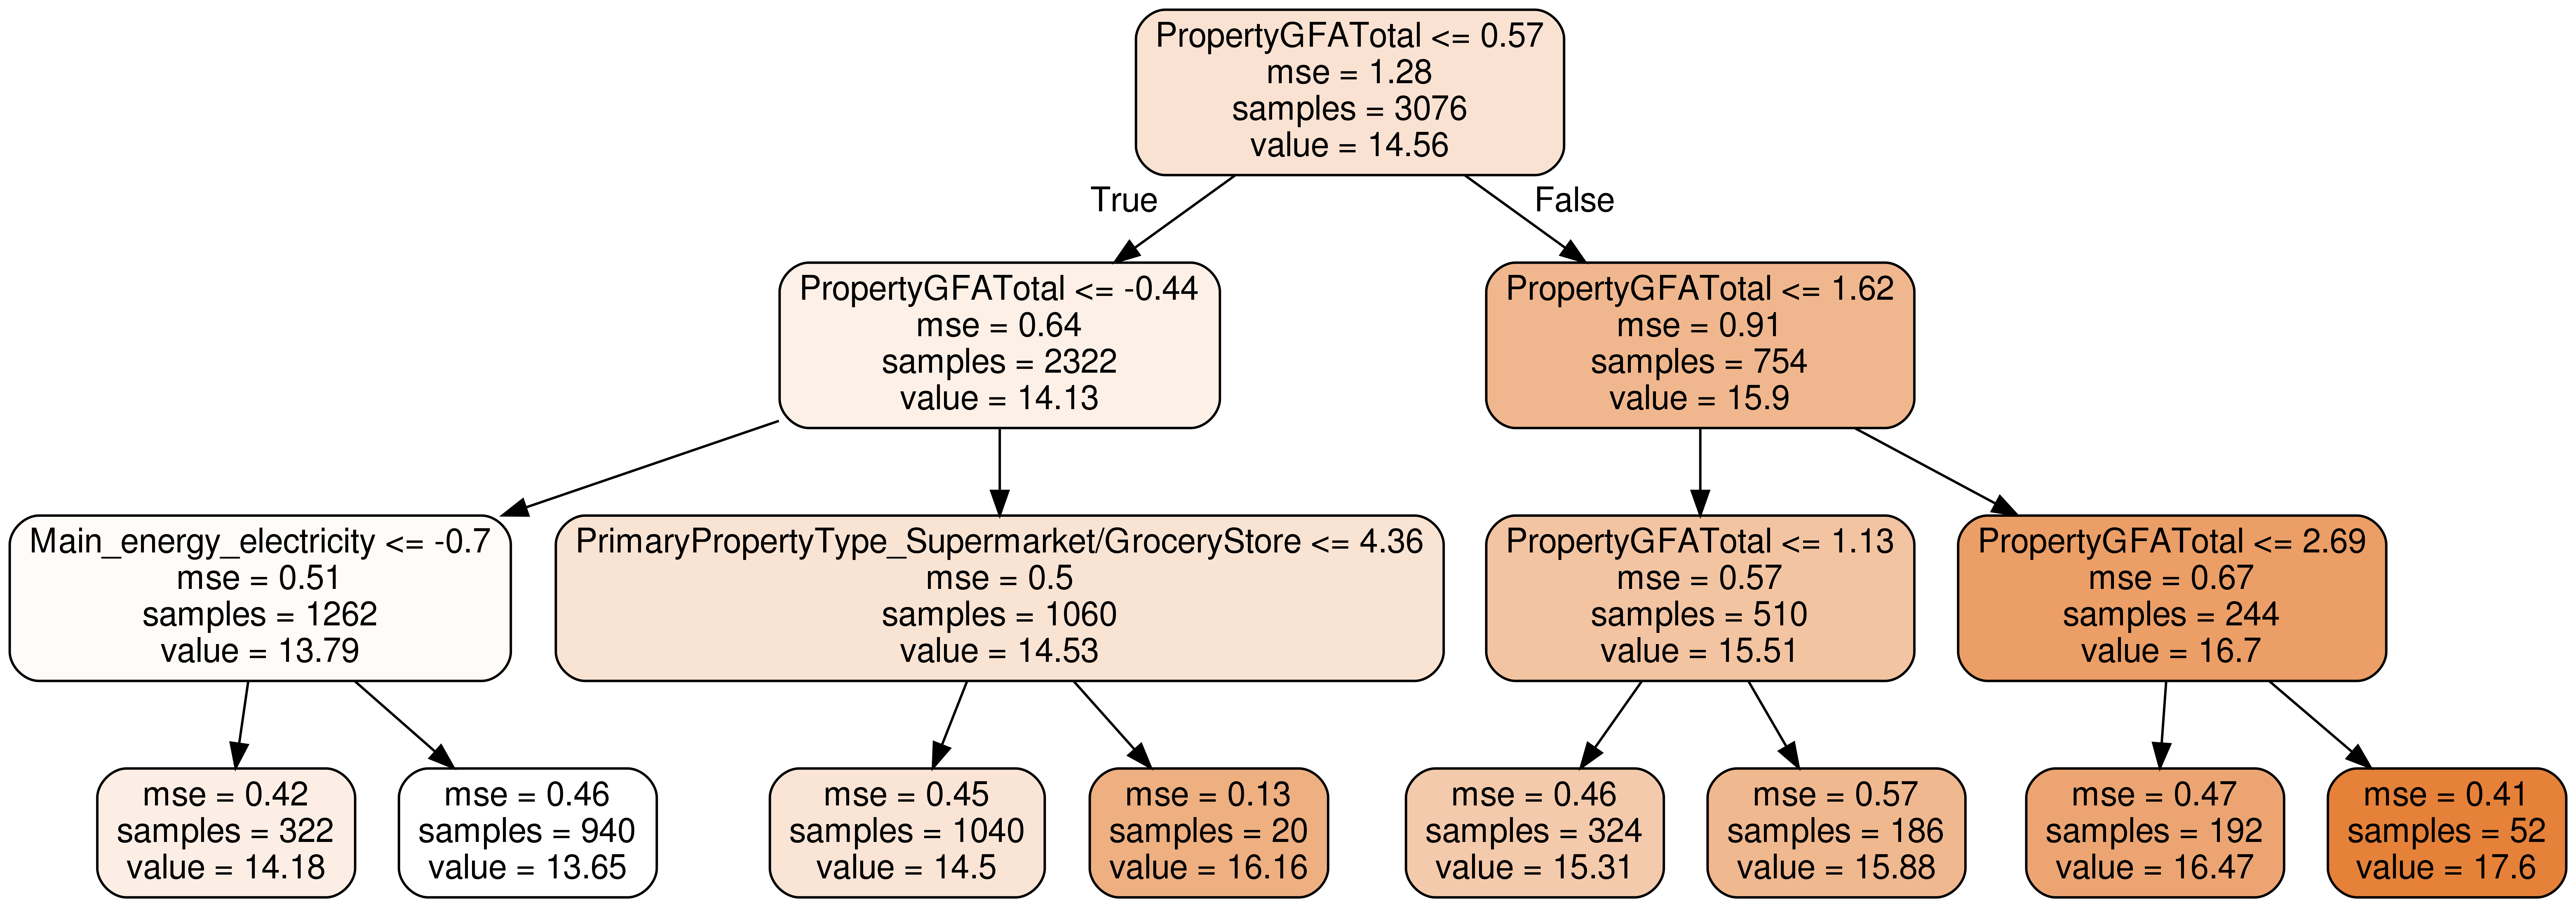

In [41]:
# Display naiv decision tree

rfr_en_naiv_model = RandomForestRegressor(n_estimators=300, random_state=42, max_depth=3)
rfr_en_naiv_model.fit(*train_and_test_data_reduced_44f['train'])

display_decision_tree(rfr_en_naiv_model,
                      rfr_en_mif_n_labels,
                      targets_cols[0],
                      tree_nb=5)

#### 1.1.8 - Training curve

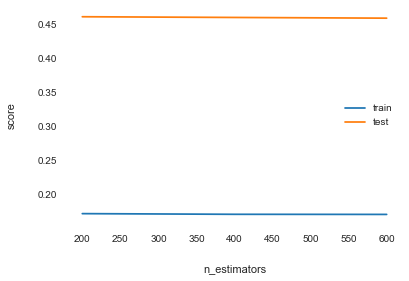

In [42]:
# Plot training curve

x_train_std_en_13f = train_and_test_data_reduced_13f['train'][0]

plot_validation_curve(RandomForestRegressor(n_estimators=300, random_state=42),
                      x_train_std_en_13f,
                      y_train_energy,
                      'n_estimators',
                      np.arange(200, 800, 200),
                      log_scale=False,
                      scorer='neg_root_mean_squared_error')

#### 1.1.9 - Learning curve

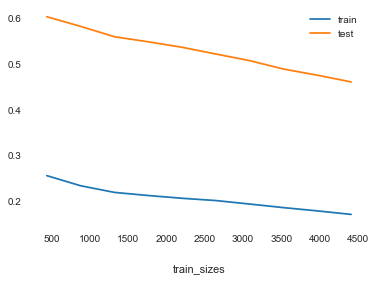

In [43]:
# Plot learning curve

plot_learning_curve(RandomForestRegressor(n_estimators=300, min_samples_leaf=1, random_state=42),
                    x_train_std_en_13f,
                    y_train_energy,
                    train_sizes_ratio=np.linspace(0.1, 1, 10),
                    scorer='neg_root_mean_squared_error')

# Potential for improvement : Yes

In [44]:
rfr_en_reduced_data_13f['learning_potential'] = 'Yes'

#### 1.2 - Random Forest (target : 'TotalGHGEmissions' ) <a class="anchor" id="rfr_1_2"></a>

#### 1.2.1 - Train model (optimize hyperparameters)

In [45]:
%%time 

# Random Forest

rfr_model = RandomForestRegressor(random_state=42) #,n_jobs=-1)

#    n_estimators range      |       max_depth range
#  np.arange(200, 550, 50)   |      [2, 4, 6, 8, 10]
# [400, 500, 600]

rfr_em_params = {'n_estimators': [500], # 350 3min
#                'max_depth': [40],
#                'max_features': ['auto', 'sqrt', 'log2']
                 'min_samples_leaf': [1]}

rfr_em_data = train_gridsearch(emissions_data,
                               rfr_model,
                               rfr_em_params,
                               k=10)

print(rfr_em_data['model'])

RandomForestRegressor
--------------------------
Testing set performances :
- RMSE = 0.53
- R2 = 0.868
--------------------------------
Training set performances (CV) :
- RMSE = 0.635
- R2 = 0.815
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)
CPU times: user 3min 26s, sys: 795 ms, total: 3min 26s
Wall time: 3min 26s


#### 1.2.2 - Select most important features (method : cumulative feature importance selection)

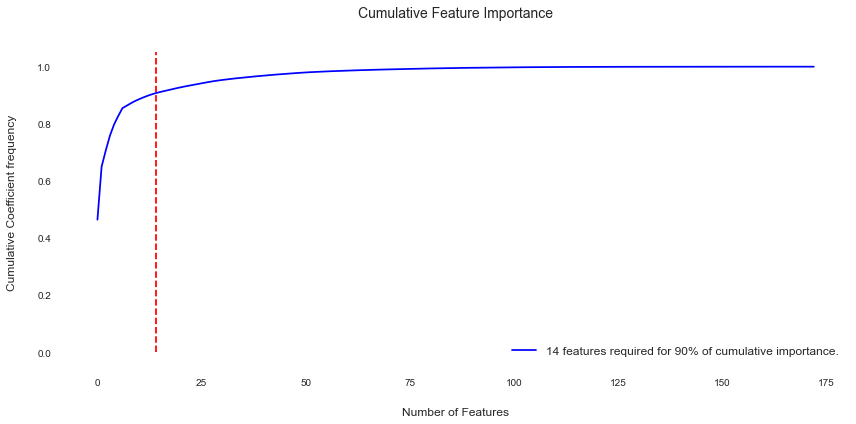

In [46]:
rfr_em_model = rfr_em_data['model']
rfr_em_coefs = rfr_em_model.feature_importances_

rfr_em_features_coefs_df = get_features_importance(training_features,
                                                   rfr_em_coefs,
                                                   abs_coefs=True,
                                                   non_zero_coefs=False,
                                                   verbose=False)

plot_cumulative_features_importance(rfr_em_features_coefs_df, threshold=0.90, plot_size=(12, 6))

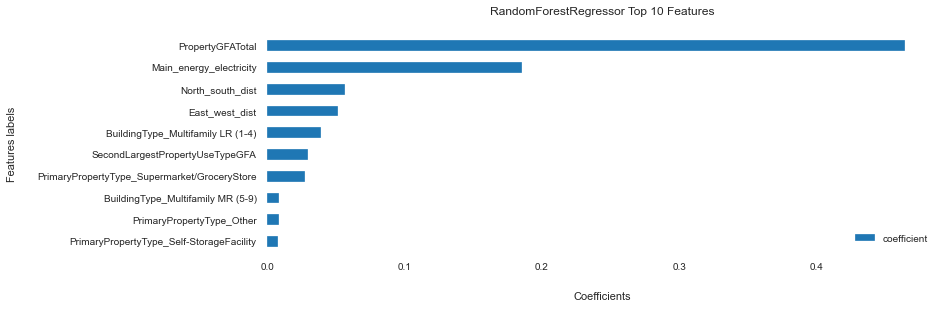

In [47]:
rfr_em_mif_13_data, rfr_em_mif_13_labels = select_most_important_features(rfr_em_features_coefs_df,
                                                                          n=13,
                                                                          method='cumsum')
# Visualize n most important features
plot_n_top_features(rfr_em_mif_13_data,
                    model_name(rfr_em_model),
                    n=10,
                    plot_size=(12, 4))

#### 1.2.3 - Second training cycle (with cumulative feature importance selection method)

In [48]:
# Second training cycle with features reduced (173 -> 13)

rfr_em_model_c2 = RandomForestRegressor(random_state=42, n_jobs=-1)

rfr_em_reduced_data_13f, train_and_test_data_reduced_13f  = run_training_cycle(rfr_em_mif_13_labels,
                                                                               rfr_em_params,
                                                                               rfr_em_model_c2) 

RandomForestRegressor
--------------------------
Testing set performances :
- RMSE = 0.396
- R2 = 0.872
--------------------------------
Training set performances (CV) :
- RMSE = 0.478
- R2 = 0.821


#### 1.2.4 - Display random decision tree (from cumulative feature importance selection method)

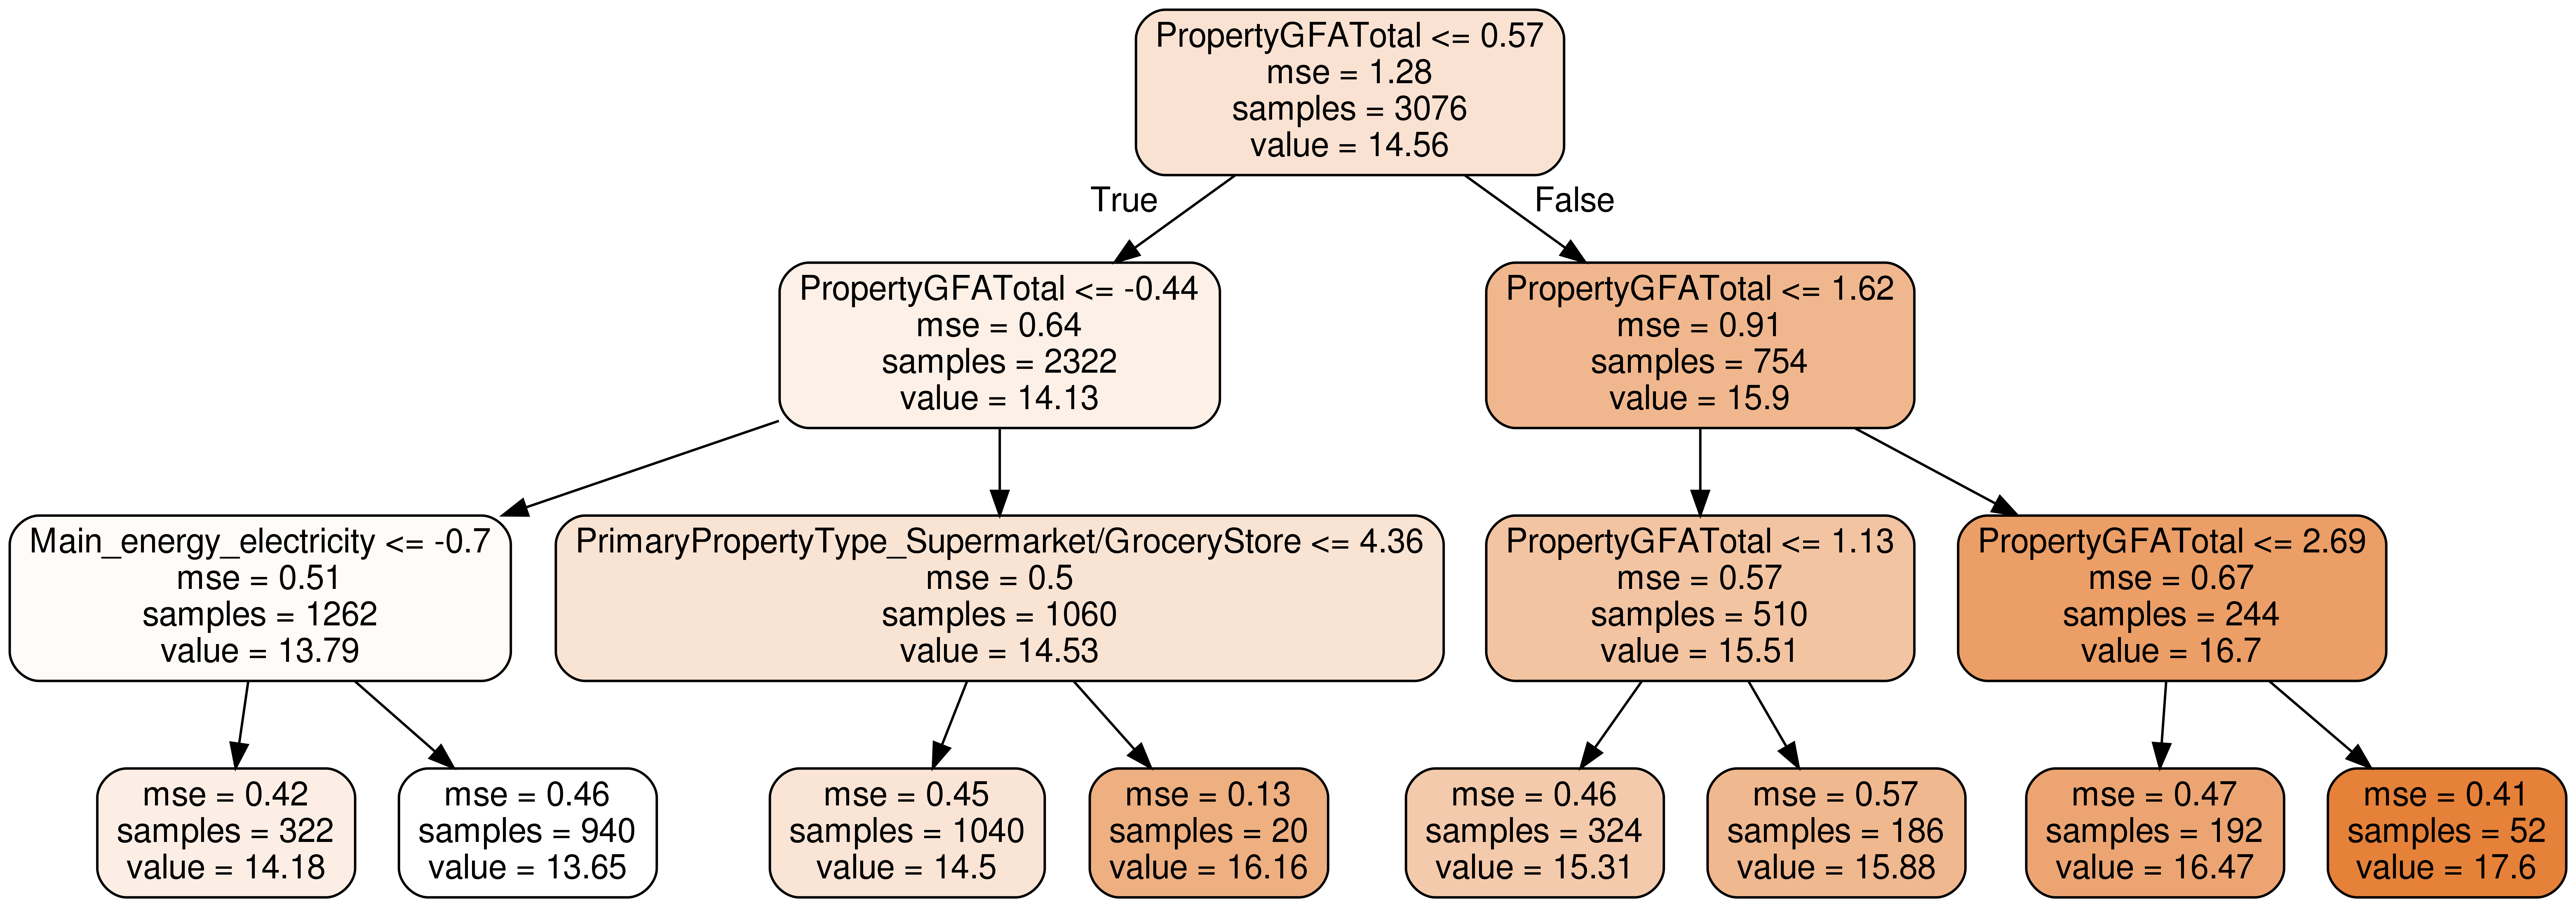

In [49]:
# Display naiv decision tree
rfr_em_naiv_model = RandomForestRegressor(n_estimators=500, random_state=42, max_depth=3)
rfr_em_naiv_model.fit(*train_and_test_data_reduced_13f['train'])

display_decision_tree(rfr_em_naiv_model,
                      rfr_em_mif_13_labels,
                      targets_cols[1],
                      tree_nb=5)

#### 1.2.5 - Select most important features (method : threshold feature importance selection)

In [50]:
rfr_em_mif_n_data, rfr_em_mif_n_labels = select_most_important_features(rfr_em_features_coefs_df,
                                                                        method='threshold',
                                                                        model=rfr_em_model,
                                                                        thr='q',
                                                                        q_value=0.75, # Q3
                                                                        v=True)

44/173 selected features, reduction of 25.4%


#### 1.2.6 - Second training cycle (with threshold feature selection method)

In [51]:
# Second training cycle with features reduced (173 -> 44)

rfr_em_model_c2 = RandomForestRegressor(random_state=42)

rfr_em_reduced_data_44f, train_and_test_data_reduced_44f = run_training_cycle(rfr_em_mif_n_labels,
                                                                              rfr_em_params,
                                                                              rfr_em_model_c2)

RandomForestRegressor
--------------------------
Testing set performances :
- RMSE = 0.376
- R2 = 0.885
--------------------------------
Training set performances (CV) :
- RMSE = 0.465
- R2 = 0.831


#### 1.2.7 - Display random decision tree (from threshold feature selection method)

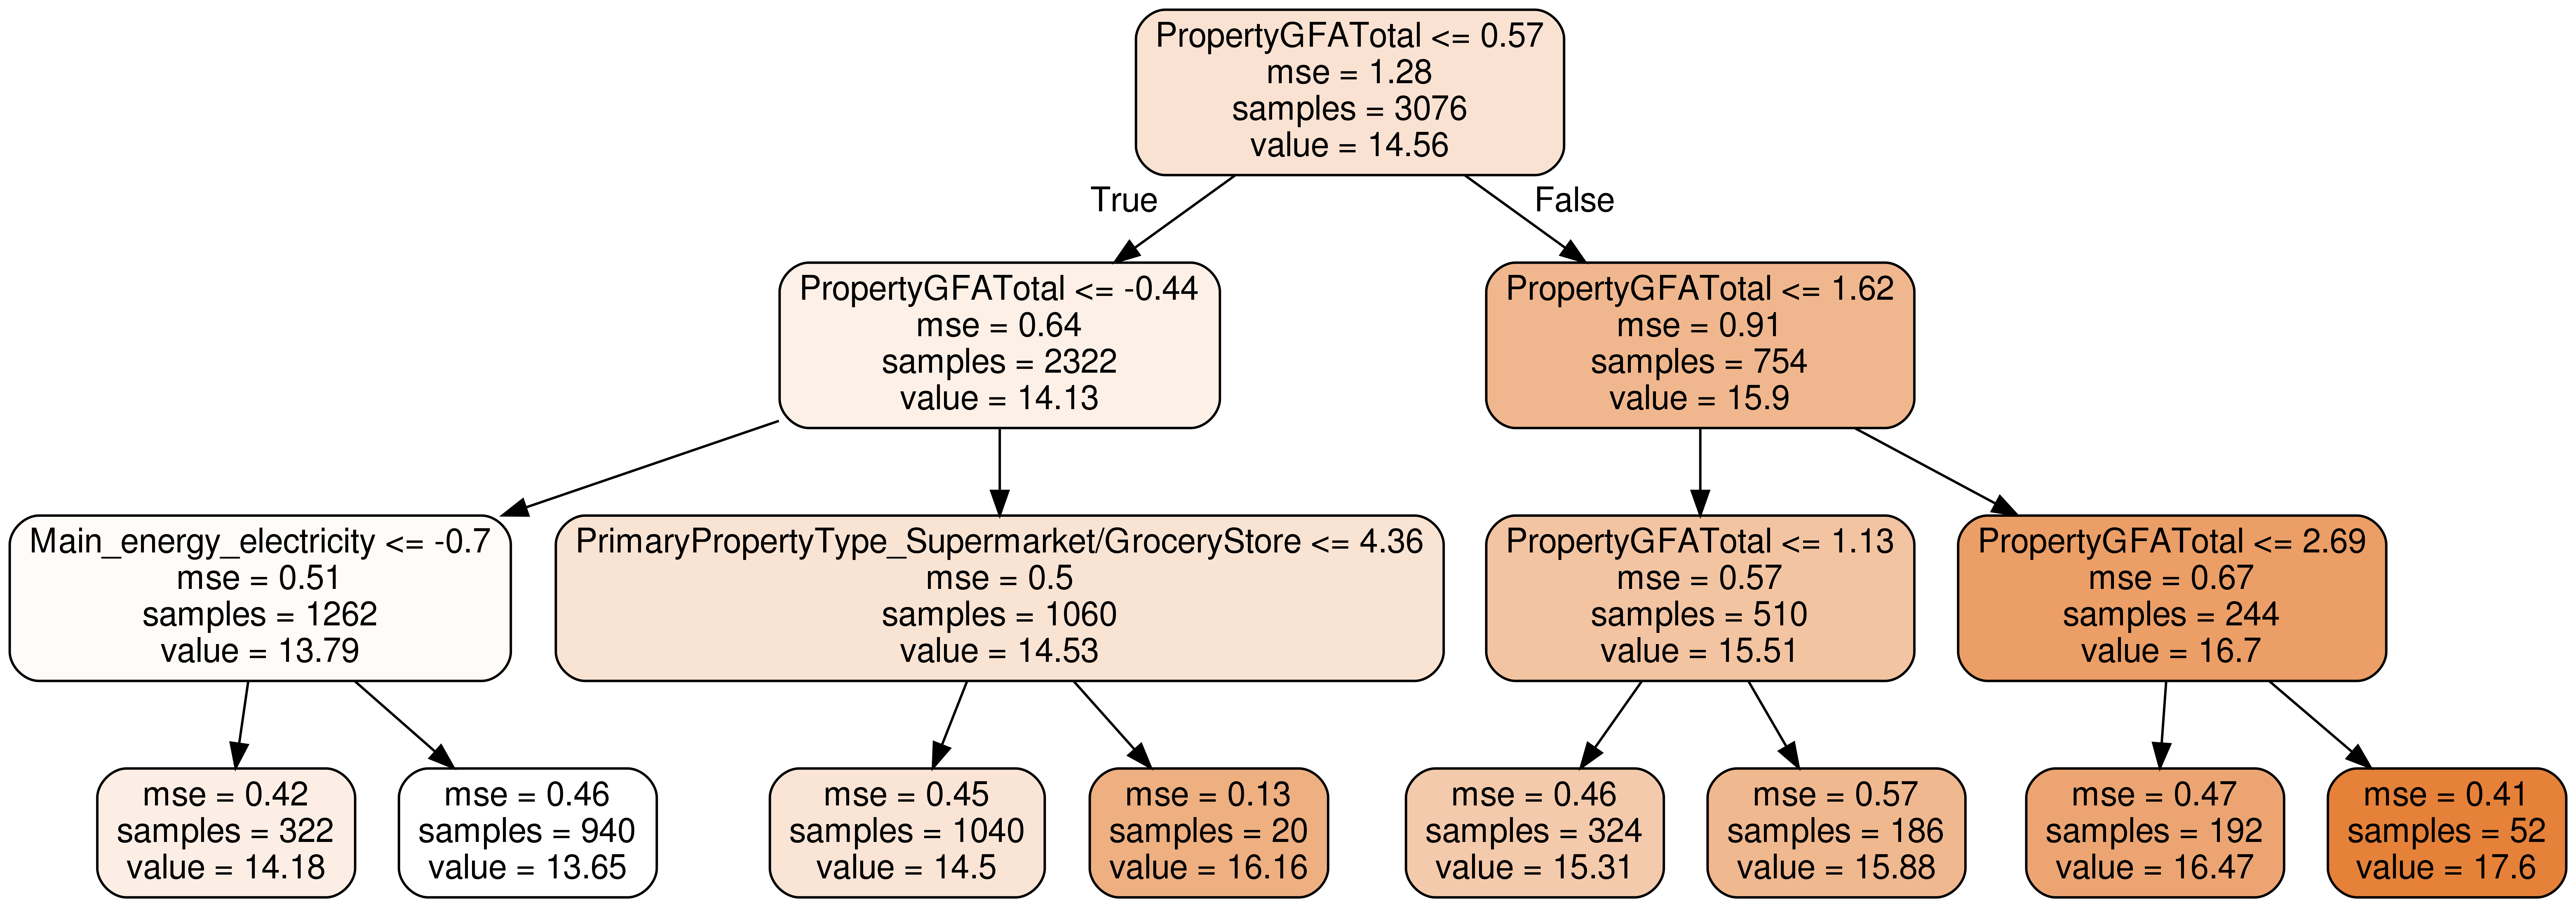

In [52]:
# Display naiv decision tree

rfr_em_naiv_model = RandomForestRegressor(n_estimators=500, random_state=42, max_depth=3)
rfr_em_naiv_model.fit(*train_and_test_data_reduced_44f['train'])

display_decision_tree(rfr_em_naiv_model,
                      rfr_em_mif_n_labels,
                      targets_cols[1],
                      tree_nb=5)

#### 1.2.8 - Training curve

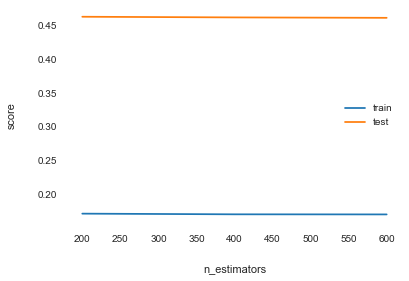

In [53]:
# Plot training curve

x_train_std_em_13f = train_and_test_data_reduced_13f['train'][0]

plot_validation_curve(RandomForestRegressor(n_estimators=500, random_state=42),
                      x_train_std_em_13f,
                      y_train_energy,
                      'n_estimators',
                      np.arange(200, 800, 200),
                      log_scale=False,
                      scorer='neg_root_mean_squared_error')

#### 1.2.9 - Learning curve

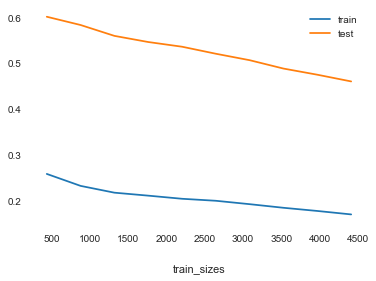

In [54]:
# Plot learning curve

plot_learning_curve(RandomForestRegressor(n_estimators=500, random_state=42),
                    x_train_std_em_13f,
                    y_train_energy,
                    train_sizes_ratio=np.linspace(0.1, 1, 10),
                    scorer='neg_root_mean_squared_error')

# Potential for improvement : Yes

In [55]:
rfr_em_reduced_data_13f['learning_potential'] = 'Yes'

#### 2.1 - XGBoost (target : 'SiteEnergyUse(kBtu)' ) <a class="anchor" id="xgb_2_1"></a>

#### 2.1.1 - Train model (optimize hyperparameters)

In [56]:
%%time

# XGBoost
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror')

# xgb_reg_params = {'n_estimators': [150, 200, 250],
#                   'alpha': [0.5, 2, 5],
#                   'learning_rate': np.arange(0.1, 1.1, 0.1),
#                   'max_depth': [5, 10, 20],
#                   'colsample_bytree': [0.3],
#                   #'subsample': np.arange(0.1, 1.1, 0.1)
#                  }

xgb_reg_en_params = {'n_estimators': [500],
                     'alpha': [0.5], # selected from np.arange(1, 2, 0.1),
                     'learning_rate': [0.062], # 0.065
                     'max_depth': [20],
                     'colsample_bytree': [0.35]
                     }

xgb_en_data = train_gridsearch(energy_data,
                               xgb_reg,
                               xgb_reg_en_params)

"""
- RMSE = 0.404
- R2 = 0.872
"""

print(xgb_en_data['model'])

XGBRegressor
--------------------------
Testing set performances :
- RMSE = 0.329
- R2 = 0.912
--------------------------------
Training set performances (CV) :
- RMSE = 0.402
- R2 = 0.872
XGBRegressor(alpha=0.5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.35, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.062, max_delta_step=0, max_depth=20,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0.5,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
CPU times: user 6min 29s, sys: 3.74 s, total: 6min 33s
Wall time: 1min 52s


#### 2.1.2 - Select most important features (method : cumulative feature importance selection)

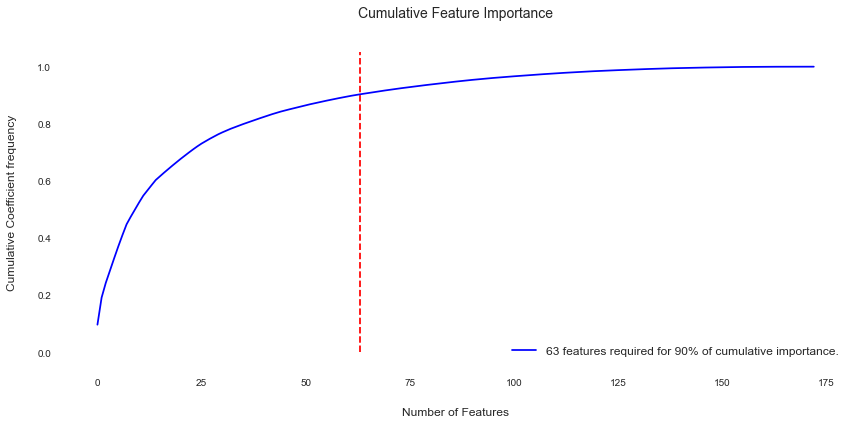

In [57]:
xgb_reg_en_model = xgb_en_data['model']
xgb_reg_en_coefs = xgb_reg_en_model.feature_importances_

xgb_reg_en_features_coefs_df = get_features_importance(training_features,
                                                       xgb_reg_en_coefs,
                                                       abs_coefs=True,
                                                       non_zero_coefs=False,
                                                       verbose=False)

plot_cumulative_features_importance(xgb_reg_en_features_coefs_df, threshold=0.90, plot_size=(12, 6))

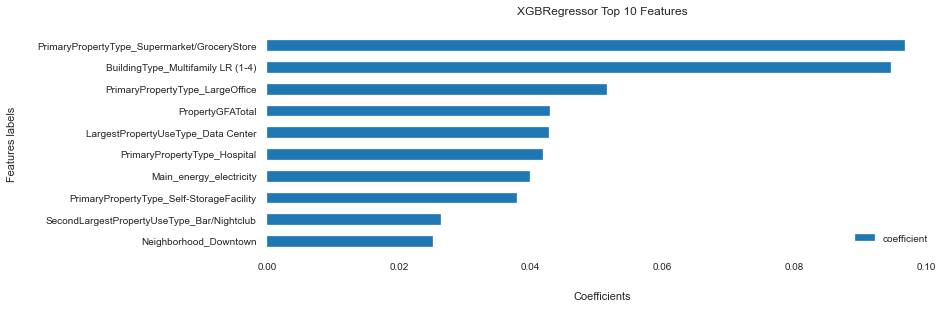

In [58]:
xgb_reg_en_mif_66_data, xgb_reg_en_mif_66_labels = select_most_important_features(xgb_reg_en_features_coefs_df,
                                                                                  n=66,
                                                                                  method='cumsum')
# Visualize n most important features
plot_n_top_features(xgb_reg_en_mif_66_data,
                    model_name(xgb_reg_en_model),
                    n=10,
                    plot_size=(12, 4))

#### 2.1.3 - Second training cycle (with cumulative feature importance selection method)

In [59]:
%%time 

# Second training cycle with features reduced (173 -> 67)

xgb_reg_en_model_c2 = xgb.XGBRegressor(objective='reg:squarederror')


xgb_reg_en_reduced_data_66f, train_and_test_data_reduced_66f  = run_training_cycle(xgb_reg_en_mif_66_labels,
                                                                                   xgb_reg_en_params,
                                                                                   xgb_reg_en_model_c2) 

XGBRegressor
--------------------------
Testing set performances :
- RMSE = 0.329
- R2 = 0.912
--------------------------------
Training set performances (CV) :
- RMSE = 0.421
- R2 = 0.861
CPU times: user 1min 38s, sys: 1.07 s, total: 1min 39s
Wall time: 28.6 s


#### 2.1.4 - Display random decision tree (from cumulative feature importance selection method)

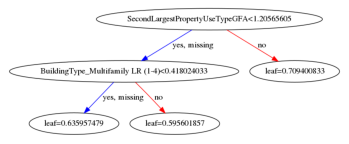

In [60]:
# Display naiv decision tree
xgb.plot_tree(xgb_reg_en_reduced_data_66f['model'], num_trees=5)
plt.show()

#### 2.1.5 - Select most important features (method : threshold feature importance selection)

In [61]:
xgb_reg_en_mif_n_data, xgb_reg_en_mif_n_labels = select_most_important_features(xgb_reg_en_features_coefs_df,
                                                                                method='threshold',
                                                                                model=xgb_reg_en_model,
                                                                                thr='q',
                                                                                q_value=0.75, # Q3
                                                                                v=True)

44/173 selected features, reduction of 25.4%


#### 2.1.6 - Second training cycle (with threshold feature selection method)

In [62]:
# Second training cycle with features reduced (173 -> 44)

xgb_reg_en_model_c2 = xgb.XGBRegressor(objective='reg:squarederror')

xgb_reg_en_reduced_data_44f, train_and_test_data_reduced_44f  = run_training_cycle(xgb_reg_en_mif_n_labels,
                                                                                   xgb_reg_en_params,
                                                                                   xgb_reg_en_model_c2) 

XGBRegressor
--------------------------
Testing set performances :
- RMSE = 0.341
- R2 = 0.905
--------------------------------
Training set performances (CV) :
- RMSE = 0.437
- R2 = 0.851


#### 2.1.7 - Display random decision tree (from threshold feature selection method)

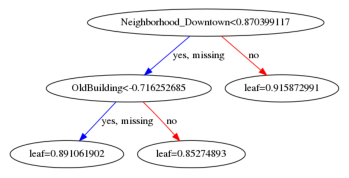

In [63]:
# Display naiv decision tree
xgb.plot_tree(xgb_reg_en_reduced_data_44f['model'], num_trees=0)
plt.show()

#### 2.1.8 - Training curve

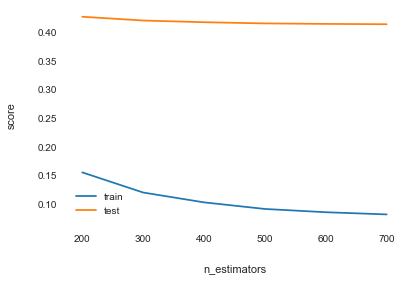

In [64]:
# Plot training curve

x_train_std_en_44f = train_and_test_data_reduced_44f['train'][0]


xgb_reg_en_params = {'objective': 'reg:squarederror',
                     'n_estimators': 500,
                     'alpha': 0.5,
                     'learning_rate': 0.062,
                     'max_depth': 20,
                     'colsample_bytree': 0.35}


plot_validation_curve(xgb.XGBRegressor(**xgb_reg_en_params),
                      x_train_std_en_44f,
                      y_train_energy,
                      'n_estimators',
                      np.arange(200, 800, 100),
                      log_scale=False,
                      scorer='neg_root_mean_squared_error')

#### 2.1.9 - Learning curve

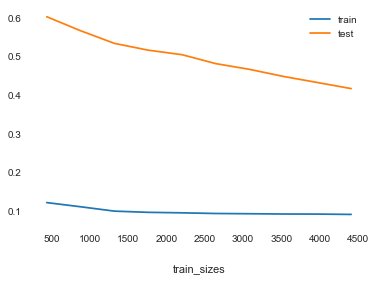

In [65]:
# Plot learning curve

plot_learning_curve(xgb.XGBRegressor(**xgb_reg_en_params),
                    x_train_std_en_44f,
                    y_train_energy,
                    train_sizes_ratio=np.linspace(0.1, 1, 10),
                    scorer='neg_root_mean_squared_error')

# Potential for improvement : Yes

In [66]:
xgb_reg_en_reduced_data_44f['learning_potential'] = 'Yes'

#### 2.2 - XGBoost (target : 'TotalGHGEmissions' ) <a class="anchor" id="xgb_2_2"></a>

#### 2.2.1 - Train model (optimize hyperparameters)

In [67]:
%%time

# XGBoost
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror')

# xgb_reg_params = {'n_estimators': [150, 200, 250, 300],
#                   'alpha': [2, 5],
#                   'learning_rate': np.arange(0.1, 1.1, 0.1),
#                   'max_depth': [5, 10, 20],
#                   'colsample_bytree': [0.3],
#                   'subsample': np.arange(0.1, 1.1, 0.1)}

xgb_reg_em_params = {'n_estimators': [500],
                     'alpha': [1.6], # selected from np.arange(1, 2, 0.1),
                     'learning_rate': [0.05],
                     'max_depth': [20],
                     'colsample_bytree': [0.35]
                    }


xgb_em_data = train_gridsearch(emissions_data,
                               xgb_reg,
                               xgb_reg_em_params)

"""
- RMSE = 0.573
- R2 = 0.852
"""

print(xgb_em_data['model'])

XGBRegressor
--------------------------
Testing set performances :
- RMSE = 0.513
- R2 = 0.877
--------------------------------
Training set performances (CV) :
- RMSE = 0.599
- R2 = 0.835
XGBRegressor(alpha=1.6, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.35, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=20,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=1.60000002,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
CPU times: user 6min 13s, sys: 2.83 s, total: 6min 15s
Wall time: 1min 40s


#### 2.2.2 - Select most important features (method : cumulative feature importance selection)

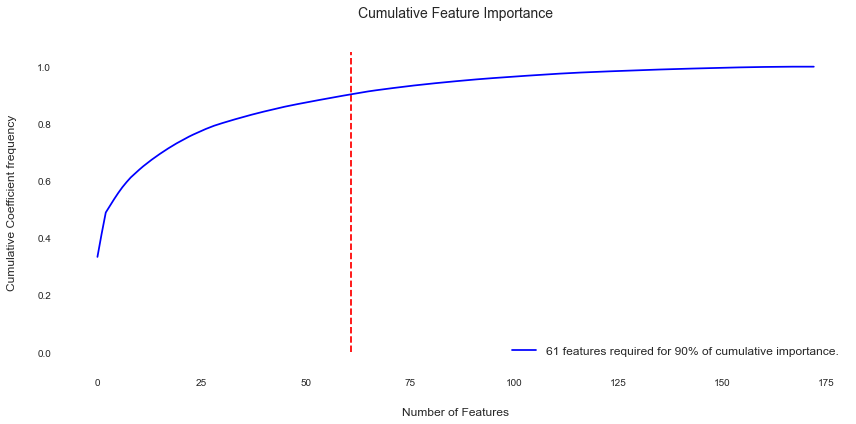

In [68]:
xgb_reg_em_model = xgb_em_data['model']
xgb_reg_em_coefs = xgb_reg_em_model.feature_importances_

xgb_reg_em_features_coefs_df = get_features_importance(training_features,
                                                       xgb_reg_em_coefs,
                                                       abs_coefs=True,
                                                       non_zero_coefs=False,
                                                       verbose=False)

plot_cumulative_features_importance(xgb_reg_em_features_coefs_df, threshold=0.90, plot_size=(12, 6))

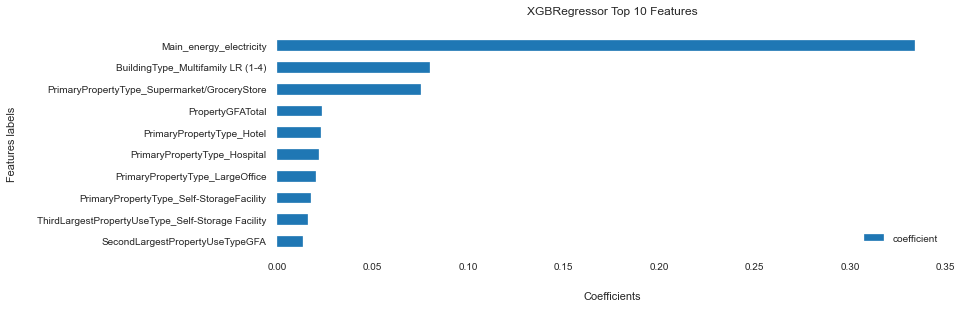

In [69]:
xgb_reg_em_mif_62_data, xgb_reg_em_mif_62_labels = select_most_important_features(xgb_reg_em_features_coefs_df,
                                                                                  n=62,
                                                                                  method='cumsum')
# Visualize n most important features
plot_n_top_features(xgb_reg_em_mif_62_data,
                    model_name(xgb_reg_em_model),
                    n=10,
                    plot_size=(12, 4))

#### 2.2.3 - Second training cycle (with cumulative feature importance selection method)

In [70]:
%%time 

# Second training cycle with features reduced (173 -> 62)

xgb_reg_em_model_c2 = xgb.XGBRegressor(objective='reg:squarederror')


xgb_reg_em_reduced_data_62f, train_and_test_data_reduced_62f  = run_training_cycle(xgb_reg_em_mif_62_labels,
                                                                                   xgb_reg_em_params,
                                                                                   xgb_reg_em_model_c2) 

XGBRegressor
--------------------------
Testing set performances :
- RMSE = 0.361
- R2 = 0.894
--------------------------------
Training set performances (CV) :
- RMSE = 0.437
- R2 = 0.851
CPU times: user 1min 9s, sys: 287 ms, total: 1min 9s
Wall time: 18.3 s


#### 2.2.4 - Display random decision tree (from cumulative feature importance selection method)

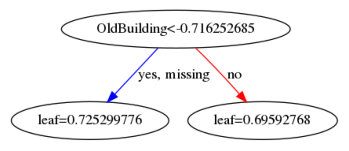

In [71]:
# Display naiv decision tree
xgb.plot_tree(xgb_reg_em_reduced_data_62f['model'], num_trees=0)
plt.show()

#### 2.2.5 - Select most important features (method : threshold feature importance selection)

In [72]:
xgb_reg_em_mif_n_data, xgb_reg_em_mif_n_labels = select_most_important_features(xgb_reg_em_features_coefs_df,
                                                                                method='threshold',
                                                                                model=xgb_reg_em_model,
                                                                                thr='q',
                                                                                q_value=0.75, # Q3
                                                                                v=True)

44/173 selected features, reduction of 25.4%


#### 2.2.6 - Second training cycle (with threshold feature selection method)

In [73]:
# Second training cycle with features reduced (173 -> 44)

xgb_reg_em_model_c2 = xgb.XGBRegressor(objective='reg:squarederror')

xgb_reg_em_reduced_data_44f, train_and_test_data_reduced_44f  = run_training_cycle(xgb_reg_em_mif_n_labels,
                                                                                   xgb_reg_em_params,
                                                                                   xgb_reg_em_model_c2) 

XGBRegressor
--------------------------
Testing set performances :
- RMSE = 0.366
- R2 = 0.891
--------------------------------
Training set performances (CV) :
- RMSE = 0.448
- R2 = 0.843


#### 2.2.7 - Display random decision tree (from threshold feature selection method)

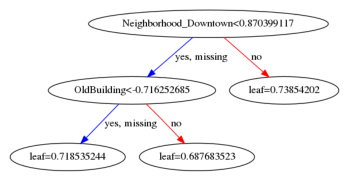

In [74]:
# Display naiv decision tree
xgb.plot_tree(xgb_reg_em_reduced_data_44f['model'], num_trees=0)
plt.show()

#### 2.2.8 - Training curve

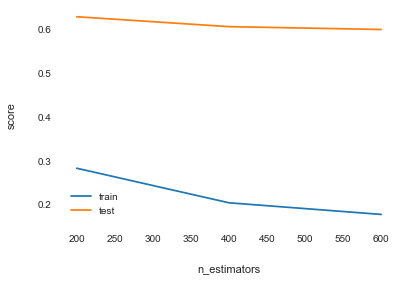

In [75]:
# Plot training curve

x_train_std_em_44f = train_and_test_data_reduced_44f['train'][0]

xgb_reg_em_params = {'objective': 'reg:squarederror',
                     'n_estimators': 500,
                     'alpha': 1.6,
                     'learning_rate': 0.05,
                     'max_depth': 20,
                     'colsample_bytree': 0.35}

plot_validation_curve(xgb.XGBRegressor(**xgb_reg_em_params),
                      x_train_std_em_44f,
                      y_train_emissions,
                      'n_estimators',
                      np.arange(200, 800, 200),
                      log_scale=False,
                      scorer='neg_root_mean_squared_error')

#### 2.2.9 - Learning curve

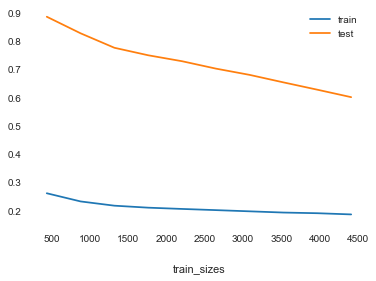

In [76]:
# Plot learning curve

plot_learning_curve(xgb.XGBRegressor(**xgb_reg_em_params),
                    x_train_std_em_44f,
                    y_train_emissions,
                    train_sizes_ratio=np.linspace(0.1, 1, 10),
                    scorer='neg_root_mean_squared_error')

# Potential for improvement : Yes

In [77]:
xgb_reg_em_reduced_data_44f['learning_potential'] = 'Yes'

### 3 - Feature Selection : union of the variables selected by the models <a class="anchor" id="third_3"></a>

In [78]:
# Get union from best models selected features for each target


# Energy best selected features


# Merge best selected features from models
en_total_best_features = enet_en_mif_34_labels + rfr_en_mif_13_labels + xgb_reg_en_mif_n_labels
# Extract best unique selected features from merged list
en_best_features = list(set(en_total_best_features))


# Emissions best selected features


# Merge best selected features from models
em_total_best_features = enet_em_mif_n_labels + rfr_em_mif_13_labels + xgb_reg_em_mif_n_labels
# Extract best unique selected features from merged list
em_best_features = list(set(em_total_best_features))

# Display best features count for each target
print('Energy target has {} best features'.format(len(en_best_features)))
print('Emissions target has {} best features'.format(len(em_best_features)))

Energy target has 53 best features
Emissions target has 54 best features


### 4 - Non linear models : Kernel SVR, MLPR <a class="anchor" id="third_4"></a>

### N.B :

Nonlinear models do not allow to measure in a simple way feature contributions from models

We will therefore proceed here differently by:
- training our models from all the features.
- carrying out a second training cycle based on the most relevant features selected by the best model (for each target)

#### 1.1 Kernel SVR (target : 'SiteEnergyUse(kBtu)' ) <a class="anchor" id="ksvr_1_1"></a>

#### 1.1.1 - Train model (optimize hyperparameters)

In [79]:
%%time

kernel_svr_model = SVR(kernel='rbf')

kernel_svr_en_params = {'C': [250], # 300 # np.arange(50, 550, 50),  np.logspace(-3, 3, 10)
                        'gamma': [0.001],
                        'epsilon': [0.1]}

kernel_svr_en_data = train_gridsearch(energy_data,
                                      kernel_svr_model,
                                      kernel_svr_en_params)
"""
- RMSE = 0.511
- R2 = 0.795
"""
kernel_svr_en_model = kernel_svr_en_data['model']
kernel_svr_en_model

SVR
--------------------------
Testing set performances :
- RMSE = 0.461
- R2 = 0.827
--------------------------------
Training set performances (CV) :
- RMSE = 0.506
- R2 = 0.799
CPU times: user 1min 40s, sys: 493 ms, total: 1min 40s
Wall time: 1min 40s


SVR(C=250, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

#### 1.1.2 - Second training cycle (with feature selection)

In [80]:
%%time 

# Second training cycle with features reduced

kernel_svr_en_model = SVR(kernel='rbf')

# We test the different sets of selected features for each model by also adding the union of these
en_selected_feature_sets_dict = {'ElasticNet': enet_en_mif_34_labels,
                                 'RandomForestRegressor': rfr_en_mif_13_labels,
                                 'XGBoostRegressor': xgb_reg_en_mif_n_labels,
                                 'Union of features selected by each model': en_best_features}


def run_training_cycle_for_each_feature_set(feature_sets, model, model_param_grid):
    # Second cycle results dictionary 
    second_cycle_results = {'rmse': [],
                            'r2': [],
                            'time': [],
                            'total selected features': [],
                            'selected features by': []}
    # Run second training cycle for each selected features lists
    for model_of_feature_set, selected_features in feature_sets.items():
        
        model_reduced_data_nf, train_and_test_data_reduced_nf = run_training_cycle(selected_features,
                                                                                   model_param_grid,
                                                                                   model,
                                                                                   v=False)
        second_cycle_results['rmse'].append(model_reduced_data_nf['rmse'])
        second_cycle_results['r2'].append(model_reduced_data_nf['r2'])
        second_cycle_results['time'].append(model_reduced_data_nf['time'])
        second_cycle_results['total selected features'].append(len(selected_features))
        second_cycle_results['selected features by'].append(model_of_feature_set)
    # Build second cycle results
    second_cycle_results_df = pd.DataFrame(second_cycle_results)
    return second_cycle_results_df


kernel_svr_en_second_cycle_results_df = run_training_cycle_for_each_feature_set(en_selected_feature_sets_dict,
                                                                                kernel_svr_en_model,
                                                                                kernel_svr_en_params)
# Best performances for each feature set
kernel_svr_en_second_cycle_results_df

CPU times: user 1min, sys: 568 ms, total: 1min 1s
Wall time: 1min 1s


rmse     r2  time  total selected features  \
0  0.493  0.803  12 s                       31   
1  0.523  0.777  10 s                       13   
2  0.486  0.808  17 s                       44   
3  0.470  0.820  22 s                       53   

                       selected features by  
0                                ElasticNet  
1                     RandomForestRegressor  
2                          XGBoostRegressor  
3  Union of features selected by each model

In [81]:
# Train best Kernel SVR model with appropriate selected features list
# Best model is selected by arbitrating between feature total and score (RMSE)
# Fewer features mean less data acquisition costs
kernel_svr_en_reduced_data_13f, train_and_test_data_reduced_13f  = run_training_cycle(rfr_en_mif_13_labels,
                                                                                      kernel_svr_en_params,
                                                                                      kernel_svr_en_model,
                                                                                      v=False)

#### 1.1.3 - Training curve

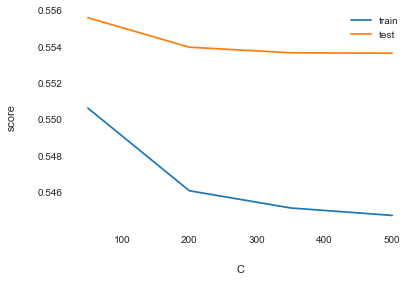

In [82]:
x_train_std_en_13f = train_and_test_data_reduced_13f['train'][0]

kernel_svr_en_params = {'kernel': 'rbf',
                        'C': 250,
                        'gamma': 0.001,
                        'epsilon': 0.1}

plot_validation_curve(SVR(**kernel_svr_en_params),
                      x_train_std_en_13f,
                      y_train_energy,
                      'C',
                      np.arange(50, 550, 150),
                      log_scale=False,
                      scorer='neg_root_mean_squared_error')

# Fix C hyperparameter to 200

In [83]:
# Train best Kernel SVR model with appropriate selected features list (and C = 200)

kernel_svr_en_params = {'C': [200],
                        'gamma': [0.001],
                        'epsilon': [0.1]}

kernel_svr_en_reduced_data_13f, train_and_test_data_reduced_13f  = run_training_cycle(rfr_en_mif_13_labels,
                                                                                      kernel_svr_en_params,
                                                                                      kernel_svr_en_model,
                                                                                      v=False)

#### 1.1.4 - Learning curve

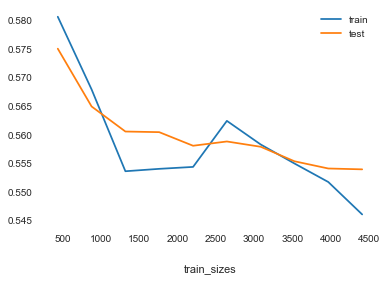

In [84]:
# Plot learning curve

x_train_std_en_13f = train_and_test_data_reduced_13f['train'][0]

kernel_svr_en_params = {'kernel': 'rbf',
                        'C': 200,
                        'gamma': 0.001,
                        'epsilon': 0.1}

# N.B : function from mlearn evaluator module
plot_learning_curve(SVR(**kernel_svr_en_params),
                    x_train_std_en_13f,
                    y_train_energy,
                    train_sizes_ratio=np.linspace(0.1, 1, 10),
                    scorer='neg_root_mean_squared_error')

# Potential for improvement : No

In [85]:
kernel_svr_en_reduced_data_13f['learning_potential'] = 'No'

#### 1.2 Kernel SVR (target : 'TotalGHGEmissions' ) <a class="anchor" id="ksvr_1_2"></a>

#### 1.2.1 - Train model (optimize hyperparameters)

In [86]:
%%time

kernel_svr_model = SVR(kernel='rbf')

kernel_svr_em_params = {'C': [250], # 300
                        'gamma': [0.001], # 0.01
                        'epsilon': [0.1]}

kernel_svr_em_data = train_gridsearch(emissions_data,
                                      kernel_svr_model,
                                      kernel_svr_em_params)
"""

"""

kernel_svr_em_data['model']

SVR
--------------------------
Testing set performances :
- RMSE = 0.719
- R2 = 0.758
--------------------------------
Training set performances (CV) :
- RMSE = 0.767
- R2 = 0.729
CPU times: user 1min 31s, sys: 297 ms, total: 1min 31s
Wall time: 1min 31s


SVR(C=250, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

#### 1.2.2 - Second training cycle (with feature selection)

In [87]:
%%time 

# Second training cycle with features reduced

kernel_svr_em_model = SVR(kernel='rbf')

# We test the different sets of selected features for each model by also adding the union of these
em_selected_feature_sets_dict = {'ElasticNet': enet_em_mif_n_labels,
                                 'RandomForestRegressor': rfr_em_mif_13_labels,
                                 'XGBoostRegressor': xgb_reg_em_mif_n_labels,
                                 'Union of features selected by each model': em_best_features}

kernel_svr_em_second_cycle_results_df = run_training_cycle_for_each_feature_set(em_selected_feature_sets_dict,
                                                                                kernel_svr_em_model,
                                                                                kernel_svr_em_params)

# Best performances for each feature set
kernel_svr_em_second_cycle_results_df

CPU times: user 1min 4s, sys: 380 ms, total: 1min 4s
Wall time: 1min 4s


rmse     r2  time  total selected features  \
0  0.483  0.810  14 s                       33   
1  0.527  0.774  10 s                       13   
2  0.482  0.811  18 s                       44   
3  0.462  0.826  21 s                       54   

                       selected features by  
0                                ElasticNet  
1                     RandomForestRegressor  
2                          XGBoostRegressor  
3  Union of features selected by each model

In [88]:
kernel_svr_em_reduced_data_13f, train_and_test_data_reduced_13f  = run_training_cycle(rfr_em_mif_13_labels,
                                                                                      kernel_svr_em_params,
                                                                                      kernel_svr_em_model,
                                                                                      v=False)

#### 1.2.3 - Training curve

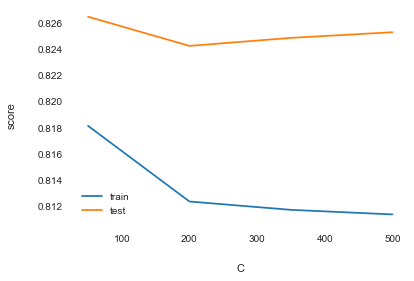

In [89]:
x_train_std_em_13f = train_and_test_data_reduced_13f['train'][0]

kernel_svm_em_params = {'kernel': 'rbf',
                        'C': 250,
                        'gamma': 0.001,
                        'epsilon': 0.1}

plot_validation_curve(SVR(**kernel_svm_em_params),
                      x_train_std_em_13f,
                      y_train_emissions,
                      'C',
                      np.arange(50, 550, 150),
                      log_scale=False,
                      scorer='neg_root_mean_squared_error')

In [90]:
# Train best Kernel SVR model with appropriate selected features list (and C = 200)

kernel_svm_em_params = {'C': [200],
                        'gamma': [0.001],
                        'epsilon': [0.1]}

kernel_svr_em_reduced_data_13f, train_and_test_data_reduced_13f  = run_training_cycle(rfr_em_mif_13_labels,
                                                                                      kernel_svm_em_params,
                                                                                      kernel_svr_em_model,
                                                                                      v=True)

SVR
--------------------------
Testing set performances :
- RMSE = 0.527
- R2 = 0.774
--------------------------------
Training set performances (CV) :
- RMSE = 0.555
- R2 = 0.759


#### 1.2.4 - Learning curve

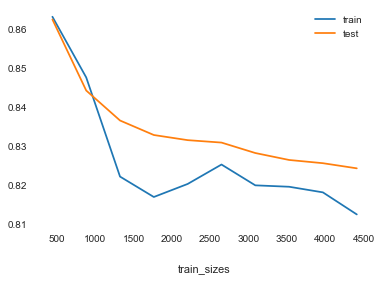

In [91]:
# Plot learning curve

x_train_std_em_13f = train_and_test_data_reduced_13f['train'][0]

kernel_svm_em_params = {'kernel': 'rbf',
                        'C': 200,
                        'gamma': 0.001,
                        'epsilon': 0.1}

# N.B : function from mlearn evaluator module
plot_learning_curve(SVR(**kernel_svm_em_params),
                    x_train_std_em_13f,
                    y_train_emissions,
                    train_sizes_ratio=np.linspace(0.1, 1, 10),
                    scorer='neg_root_mean_squared_error')

# Potential for improvement : No

In [92]:
kernel_svr_em_reduced_data_13f['learning_potential'] = 'No'

#### 2.1 - Multi-Layer Perceptron Regressor (target : 'SiteEnergyUse(kBtu)' ) <a class="anchor" id="mlpr_2_1"></a>

#### 2.1.1 - Train model (optimize hyperparameters)

In [93]:
%%time 

# Multi-Layer Perceptron Regressor

mlpr_model = MLPRegressor(activation='relu', #'identity',
                          learning_rate='adaptive',
                          alpha=4,
                          max_iter=5000,
                          verbose=False)

mlpr_en_params = {'hidden_layer_sizes': (16, 3), # pow(16, 3) < df.shape[0]
                  'learning_rate_init': [0.0008]} # 0.001

mlpr_en_data = train_gridsearch(energy_data,
                                mlpr_model,
                                mlpr_en_params)
mlpr_en_data['model']

MLPRegressor
--------------------------
Testing set performances :
- RMSE = 0.463
- R2 = 0.826
--------------------------------
Training set performances (CV) :
- RMSE = 0.52
- R2 = 0.787
CPU times: user 5min 23s, sys: 2min 26s, total: 7min 50s
Wall time: 2min 57s


MLPRegressor(activation='relu', alpha=4, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=16, learning_rate='adaptive',
             learning_rate_init=0.0008, max_fun=15000, max_iter=5000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

#### 2.1.2 - Second training cycle (with feature selection)

In [94]:
%%time 

# Second training cycle with features reduced

mlpr_en_model = MLPRegressor(activation='relu',
                             learning_rate='adaptive',
                             alpha=4,
                             max_iter=5000,
                             verbose=False)

# Build second cycle results
mlpr_en_second_cycle_results_df = run_training_cycle_for_each_feature_set(en_selected_feature_sets_dict,
                                                                          mlpr_en_model,
                                                                          mlpr_en_params)
# Best performances for each feature set 
mlpr_en_second_cycle_results_df

CPU times: user 4min 21s, sys: 3.84 s, total: 4min 25s
Wall time: 4min 18s


rmse     r2       time  total selected features  \
0  0.496  0.800  1 min 3 s                       31   
1  0.534  0.768  1 min 2 s                       13   
2  0.493  0.802  1 min 5 s                       44   
3  0.479  0.813  1 min 8 s                       53   

                       selected features by  
0                                ElasticNet  
1                     RandomForestRegressor  
2                          XGBoostRegressor  
3  Union of features selected by each model

In [95]:
mlpr_en_reduced_data_13f, train_and_test_data_reduced_13f  = run_training_cycle(rfr_en_mif_13_labels,
                                                                                mlpr_en_params,
                                                                                mlpr_en_model,
                                                                                v=False)

#### 2.1.3 - Training curve

/home/adil/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


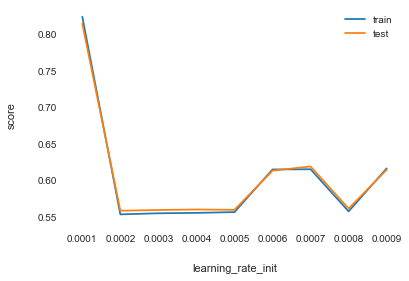

In [96]:
x_train_std_en_13f = train_and_test_data_reduced_13f['train'][0]

mlpr_en_params = {'activation': 'relu',
                  'learning_rate': 'adaptive',
                  'alpha': 4,
                  'max_iter': 5000,
                  'hidden_layer_sizes': (16, 3),
                  'learning_rate_init': 0.0008}

plot_validation_curve(MLPRegressor(**mlpr_en_params),
                      x_train_std_en_13f,
                      y_train_energy,
                      'learning_rate_init',
                      np.arange(0.0001, 0.001, 0.0001),
                      log_scale=False,
                      scorer='neg_root_mean_squared_error')

# 0.0001 seems to be a better learning rate 

In [97]:
# Run another training cycle with a learning rate = 0.0001

mlpr_en_params = {'hidden_layer_sizes': (16, 3),
                  'learning_rate_init': [0.0001]} 

mlpr_en_reduced_data_13f, train_and_test_data_reduced_13f  = run_training_cycle(rfr_en_mif_13_labels,
                                                                                mlpr_en_params,
                                                                                mlpr_en_model,
                                                                                v=True)

MLPRegressor
--------------------------
Testing set performances :
- RMSE = 0.527
- R2 = 0.774
--------------------------------
Training set performances (CV) :
- RMSE = 0.56
- R2 = 0.755


#### 2.1.4 - Learning curve

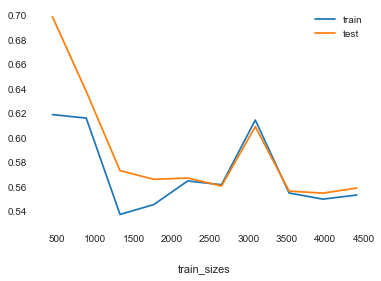

In [98]:
# Plot learning curve

x_train_std_en_13f = train_and_test_data_reduced_13f['train'][0]

mlpr_en_params = {'activation': 'relu',
                  'learning_rate': 'adaptive',
                  'alpha': 4,
                  'max_iter': 50000,
                  'hidden_layer_sizes': (16, 3),
                  'learning_rate_init': 0.0001}

# N.B : function from mlearn evaluator module
plot_learning_curve(MLPRegressor(**mlpr_en_params),
                    x_train_std_en_13f,
                    y_train_energy,
                    train_sizes_ratio=np.linspace(0.1, 1, 10),
                    scorer='neg_root_mean_squared_error')

# Potential for improvement : Yes

In [99]:
mlpr_en_reduced_data_13f['learning_potential'] = 'Yes'

#### 2.2 - Multi-Layer Perceptron Regressor (target : 'TotalGHGEmissions' ) <a class="anchor" id="mlpr_2_2"></a>

#### 2.2.1 - Train model (optimize hyperparameters)

In [100]:
%%time 

mlpr_model = MLPRegressor(activation='relu', #'identity',
                          learning_rate='adaptive',
                          alpha=4,
                          max_iter=5000,
                          verbose=False)

mlpr_em_params = {'hidden_layer_sizes': (16, 3), # pow(16, 3) < df.shape[0]
                  'learning_rate_init': [0.00075]} # 0.001

mlpr_em_data = train_gridsearch(emissions_data,
                                mlpr_model,
                                mlpr_em_params)

mlpr_em_data['model']

MLPRegressor
--------------------------
Testing set performances :
- RMSE = 0.688
- R2 = 0.778
--------------------------------
Training set performances (CV) :
- RMSE = 0.756
- R2 = 0.738
CPU times: user 4min 4s, sys: 2min 16s, total: 6min 20s
Wall time: 2min 39s


MLPRegressor(activation='relu', alpha=4, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=16, learning_rate='adaptive',
             learning_rate_init=0.00075, max_fun=15000, max_iter=5000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

#### 2.2.2 - Second training cycle (with feature selection)

In [101]:
%%time 

# Second training cycle with features reduced

mlpr_em_model = MLPRegressor(activation='relu',
                             learning_rate='adaptive',
                             alpha=4,
                             max_iter=5000,
                             verbose=False)

# Build second cycle results
mlpr_em_second_cycle_results_df = run_training_cycle_for_each_feature_set(em_selected_feature_sets_dict,
                                                                          mlpr_em_model,
                                                                          mlpr_em_params)
mlpr_em_second_cycle_results_df
# Best performances came from en_best_features (energy selected features union)

CPU times: user 6min 33s, sys: 3.54 s, total: 6min 37s
Wall time: 6min 34s


rmse     r2        time  total selected features  \
0  0.496  0.800  1 min 37 s                       33   
1  0.535  0.767  1 min 36 s                       13   
2  0.501  0.795  1 min 46 s                       44   
3  0.488  0.806  1 min 35 s                       54   

                       selected features by  
0                                ElasticNet  
1                     RandomForestRegressor  
2                          XGBoostRegressor  
3  Union of features selected by each model

In [102]:
mlpr_em_reduced_data_13f, train_and_test_data_reduced_13f  = run_training_cycle(rfr_em_mif_13_labels,
                                                                                mlpr_em_params,
                                                                                mlpr_em_model,
                                                                                v=False)

#### 2.2.3 - Training curve

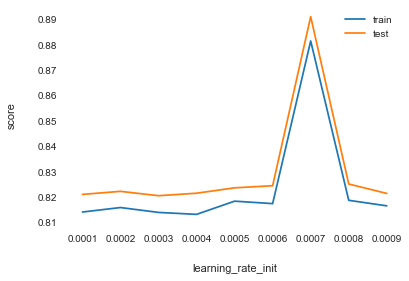

In [103]:
x_train_std_em_13f = train_and_test_data_reduced_13f['train'][0]

mlpr_em_params = {'activation': 'relu',
                  'learning_rate': 'adaptive',
                  'alpha': 4,
                  'max_iter': 5000,
                  'hidden_layer_sizes': (16, 3),
                  'learning_rate_init': 0.00075}

plot_validation_curve(MLPRegressor(**mlpr_em_params),
                      x_train_std_em_13f,
                      y_train_emissions,
                      'learning_rate_init',
                      np.arange(0.0001, 0.001, 0.0001),
                      log_scale=False,
                      scorer='neg_root_mean_squared_error')

In [104]:
# 0.0002 seems to be a better value for learning rate 

mlpr_em_model = MLPRegressor(activation='relu', #'identity',
                             learning_rate='adaptive',
                             alpha=4,
                             max_iter=5000,
                             verbose=False)

mlpr_em_params = {'hidden_layer_sizes': (16, 3),
                  'learning_rate_init': [0.0002]}

mlpr_em_reduced_data_13f, train_and_test_data_reduced_13f  = run_training_cycle(rfr_em_mif_13_labels,
                                                                                mlpr_em_params,
                                                                                mlpr_em_model,
                                                                                v=True)

MLPRegressor
--------------------------
Testing set performances :
- RMSE = 0.531
- R2 = 0.77
--------------------------------
Training set performances (CV) :
- RMSE = 0.56
- R2 = 0.755


#### 2.2.4 - Learning curve

/home/adil/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/adil/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/adil/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


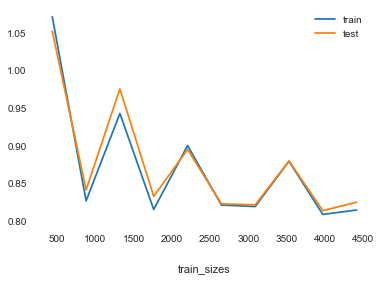

In [105]:
# Plot learning curve

x_train_std_em_13f = train_and_test_data_reduced_13f['train'][0]

mlpr_em_params = {'activation': 'relu',
                  'learning_rate': 'adaptive',
                  'alpha': 4,
                  'max_iter': 5000,
                  'hidden_layer_sizes': (16, 3),
                  'learning_rate_init': 0.0002}

# N.B : function from mlearn evaluator module
plot_learning_curve(MLPRegressor(**mlpr_em_params),
                    x_train_std_em_13f,
                    y_train_emissions,
                    train_sizes_ratio=np.linspace(0.1, 1, 10),
                    scorer='neg_root_mean_squared_error')

# Potential for improvement : No
# Critical train size threshold : 3 500 observations

In [106]:
mlpr_em_reduced_data_13f['learning_potential'] = 'No'

### 5 - Third training cycle with models union features : RandomForest, XGBoost <a class="anchor" id="third_5"></a>

#### 1.1 - Random forest (target : 'SiteEnergyUse(kBtu)' ) <a class="anchor" id="rfr_1_1_1"></a>

#### 1.1.1 - Third training cycle (with feature selection)

In [107]:
%%time 

# Third training cycle with features reduced

rfr_en_model = RandomForestRegressor(random_state=42)

rfr_en_params = {'n_estimators': [500],
                 'min_samples_leaf': [1]}

rfr_en_third_cycle_results_df = run_training_cycle_for_each_feature_set(en_selected_feature_sets_dict,
                                                                        rfr_en_model,
                                                                        rfr_en_params)

CPU times: user 3min 15s, sys: 550 ms, total: 3min 15s
Wall time: 3min 15s


In [108]:
rfr_en_third_cycle_results_df

rmse     r2       time  total selected features  \
0  0.405  0.867       38 s                       31   
1  0.392  0.875       45 s                       13   
2  0.388  0.877       49 s                       44   
3  0.376  0.885  1 min 4 s                       53   

                       selected features by  
0                                ElasticNet  
1                     RandomForestRegressor  
2                          XGBoostRegressor  
3  Union of features selected by each model

#### 1.2 - Random forest (target : 'TotalGHGEmissions') <a class="anchor" id="rfr_1_1_2"></a>

#### 1.2.1 - Third training cycle (with feature selection)

In [109]:
%%time 

# Third training cycle with features reduced

rfr_em_model = RandomForestRegressor(random_state=42)

rfr_em_params = {'n_estimators': [500],
                 'min_samples_leaf': [1]}

rfr_em_third_cycle_results_df = run_training_cycle_for_each_feature_set(em_selected_feature_sets_dict,
                                                                        rfr_em_model,
                                                                        rfr_em_params)

CPU times: user 3min 43s, sys: 447 ms, total: 3min 44s
Wall time: 3min 44s


In [110]:
rfr_em_third_cycle_results_df

rmse     r2       time  total selected features  \
0  0.388  0.878       51 s                       33   
1  0.396  0.872       45 s                       13   
2  0.381  0.882  1 min 1 s                       44   
3  0.377  0.884  1 min 7 s                       54   

                       selected features by  
0                                ElasticNet  
1                     RandomForestRegressor  
2                          XGBoostRegressor  
3  Union of features selected by each model

#### 2.1 - XGBoost (target : 'SiteEnergyUse(kBtu)' ) <a class="anchor" id="xgb_2_1_1"></a>

#### 2.1.1 - Third training cycle (with feature selection)

In [111]:
%%time 

# Third training cycle with features reduced

xgb_reg_en_model = xgb.XGBRegressor(objective='reg:squarederror')

xgb_reg_en_params = {'n_estimators': [500],
                     'alpha': [0.5],
                     'learning_rate': [0.062],
                     'max_depth': [20],
                     'colsample_bytree': [0.35]
                     }

xgb_reg_en_third_cycle_results_df = run_training_cycle_for_each_feature_set(en_selected_feature_sets_dict,
                                                                            xgb_reg_en_model,
                                                                            xgb_reg_en_params)
xgb_reg_en_third_cycle_results_df

CPU times: user 2min 58s, sys: 476 ms, total: 2min 58s
Wall time: 45.3 s


rmse     r2  time  total selected features  \
0  0.383  0.881   9 s                       31   
1  0.369  0.889   8 s                       13   
2  0.341  0.905  12 s                       44   
3  0.337  0.908  16 s                       53   

                       selected features by  
0                                ElasticNet  
1                     RandomForestRegressor  
2                          XGBoostRegressor  
3  Union of features selected by each model

In [112]:
xgb_reg_en_model = xgb.XGBRegressor(objective='reg:squarederror')

xgb_reg_en_reduced_data_13f, train_and_test_data_reduced_13f  = run_training_cycle(rfr_en_mif_13_labels,
                                                                                   xgb_reg_en_params,
                                                                                   xgb_reg_en_model,
                                                                                   v=False)

#### 2.1.2 - Training curve

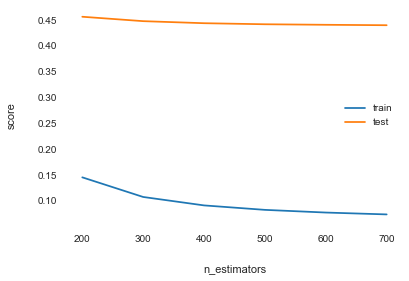

In [113]:
# Plot training curve

x_train_std_en_13f = train_and_test_data_reduced_13f['train'][0]


xgb_reg_en_params = {'objective': 'reg:squarederror',
                     'n_estimators': 500,
                     'alpha': 0.5,
                     'learning_rate': 0.062,
                     'max_depth': 20,
                     'colsample_bytree': 0.35}


plot_validation_curve(xgb.XGBRegressor(**xgb_reg_en_params),
                      x_train_std_en_13f,
                      y_train_energy,
                      'n_estimators',
                      np.arange(200, 800, 100),
                      log_scale=False,
                      scorer='neg_root_mean_squared_error')

#### 2.1.3 - Learning curve

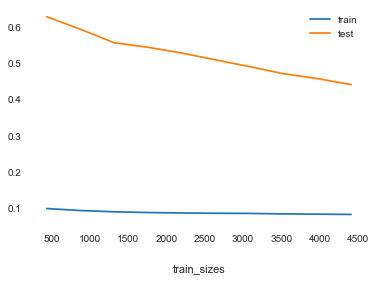

In [114]:
# Plot learning curve

plot_learning_curve(xgb.XGBRegressor(**xgb_reg_en_params),
                    x_train_std_en_13f,
                    y_train_energy,
                    train_sizes_ratio=np.linspace(0.1, 1, 10),
                    scorer='neg_root_mean_squared_error')

# Potential for improvement : Yes

In [115]:
xgb_reg_en_reduced_data_13f['learning_potential'] = 'Yes'

#### 2.2 - XGBoost (target : 'TotalGHGEmissions' ) <a class="anchor" id="xgb_2_1_2"></a>

#### 2.2.1 - Third training cycle (with feature selection)

In [116]:
%%time 

# Third training cycle with features reduced

xgb_reg_em_model = xgb.XGBRegressor(objective='reg:squarederror')

xgb_reg_em_params = {'n_estimators': [500],
                     'alpha': [1.6], 
                     'learning_rate': [0.05],
                     'max_depth': [20],
                     'colsample_bytree': [0.35]
                    }

xgb_reg_em_third_cycle_results_df = run_training_cycle_for_each_feature_set(em_selected_feature_sets_dict,
                                                                            xgb_reg_em_model,
                                                                            xgb_reg_em_params)
xgb_reg_em_third_cycle_results_df

CPU times: user 2min 58s, sys: 535 ms, total: 2min 59s
Wall time: 45.6 s


rmse     r2  time  total selected features  \
0  0.388  0.877  10 s                       33   
1  0.403  0.868   7 s                       13   
2  0.366  0.891  13 s                       44   
3  0.365  0.891  15 s                       54   

                       selected features by  
0                                ElasticNet  
1                     RandomForestRegressor  
2                          XGBoostRegressor  
3  Union of features selected by each model

In [117]:
xgb_reg_em_model = xgb.XGBRegressor(objective='reg:squarederror')

xgb_reg_em_reduced_data_13f, train_and_test_data_reduced_13f  = run_training_cycle(rfr_em_mif_13_labels,
                                                                                   xgb_reg_em_params,
                                                                                   xgb_reg_em_model,
                                                                                   v=False)

#### 2.2.2 - Training curve

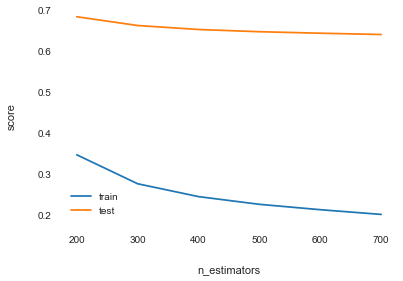

In [118]:
# Plot training curve

x_train_std_em_13f = train_and_test_data_reduced_13f['train'][0]


xgb_reg_em_params = {'objective': 'reg:squarederror',
                     'n_estimators': 500,
                     'alpha': 1.6,
                     'learning_rate': 0.05,
                     'max_depth': 20,
                     'colsample_bytree': 0.35}


plot_validation_curve(xgb.XGBRegressor(**xgb_reg_em_params),
                      x_train_std_em_13f,
                      y_train_emissions,
                      'n_estimators',
                      np.arange(200, 800, 100),
                      log_scale=False,
                      scorer='neg_root_mean_squared_error')

#### 2.2.3 - Learning curve

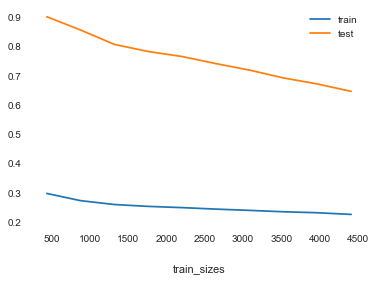

In [119]:
# Plot learning curve

plot_learning_curve(xgb.XGBRegressor(**xgb_reg_em_params),
                    x_train_std_em_13f,
                    y_train_emissions,
                    train_sizes_ratio=np.linspace(0.1, 1, 10),
                    scorer='neg_root_mean_squared_error')

# Potential for improvement : Yes

In [120]:
xgb_reg_em_reduced_data_13f['learning_potential'] = 'Yes'

# IV - Results <a class="anchor" id="fourth"></a>

### 1 - Training results <a class="anchor" id="fourth_1"></a>

In [121]:
# Best models for energy target (model data dictionaries from train_gridsearch wrapper)
best_en_models = [enet_en_reduced_data_34f,
                  rfr_en_reduced_data_13f,
                  xgb_reg_en_reduced_data_13f, #xgb_reg_en_reduced_data_44f,
                  kernel_svr_en_reduced_data_13f,
                  mlpr_en_reduced_data_13f]

# Best models for emissions target (model data dictionaries from train_gridsearch wrapper)
best_em_models = [enet_em_reduced_data_35f,
                  rfr_em_reduced_data_13f,
                  xgb_reg_em_reduced_data_13f, #xgb_reg_em_reduced_data_44f,
                  kernel_svr_em_reduced_data_13f,
                  mlpr_em_reduced_data_13f]

# Build main evaluation variables list from a random model data dictionary
model_data_keys = dict(list(rfr_en_reduced_data_13f.items())[2:])
# --> ['model_name', 'rmse', 'r2', 'time', 'n_features', 'learning_potential']

# Build main evaluation variables for result dataframes
training_results_keys = ['Model', 'RMSE', 'R2', 'Run time', 'Selected features', 'Learning potential']

# Build result dictionaries for each target
energy_training_results = {k: [] for k in training_results_keys}
emissions_training_results = {k: [] for k in training_results_keys}

# Fill result dictionaries with model data for each target
for en_model, em_model in zip(best_en_models, best_em_models):
    for k1, k2 in zip(training_results_keys, model_data_keys):
        energy_training_results[k1].append(en_model[k2])
        emissions_training_results[k1].append(em_model[k2])


target_dicts = [energy_training_results, emissions_training_results]

# Build result dataframes for each target
en_results_df, em_results_df = [pd.DataFrame(target_dict) for target_dict in target_dicts]

#### 1.1 - Training results (target : 'SiteEnergyUse(kBtu)') <a class="anchor" id="fourth_1_1"></a>

In [122]:
en_results_df
# Best model XGBRegressor

Model   RMSE     R2    Run time  Selected features  \
0           ElasticNetCV  0.499  0.798                             31   
1  RandomForestRegressor  0.392  0.875        27 s                 13   
2           XGBRegressor  0.369  0.889         8 s                 13   
3                    SVR  0.523  0.777         9 s                 13   
4           MLPRegressor  0.527  0.774  2 min 51 s                 13   

  Learning potential  
0                 No  
1                Yes  
2                Yes  
3                 No  
4                Yes

#### 1.2 - Training results (target : 'TotalGHGEmissions')  <a class="anchor" id="fourth_1_2"></a>

In [123]:
em_results_df
# Best model XGBRegressor

Model   RMSE     R2    Run time  Selected features  \
0           ElasticNetCV  0.498  0.798                             33   
1  RandomForestRegressor  0.396  0.872        21 s                 13   
2           XGBRegressor  0.403  0.868         7 s                 13   
3                    SVR  0.527  0.774         9 s                 13   
4           MLPRegressor  0.531  0.770  2 min 29 s                 13   

  Learning potential  
0                 No  
1                Yes  
2                Yes  
3                 No  
4                 No

#### 1.3 - Save results data  <a class="anchor" id="fourth_1_3"></a>

In [124]:
# Energy target ('SiteEnergyUse(kBtu)') results
en_results_data = {'en_results_df': en_results_df,
                   'en_best_model': xgb_reg_en_reduced_data_13f,
                   'en_best_features': rfr_en_mif_13_labels}

# Emissions target ('TotalGHGEmissions') results
em_results_data = {'em_results_df': em_results_df,
                   'em_best_model': xgb_reg_em_reduced_data_13f,
                   'em_best_features': rfr_em_mif_13_labels}

# Merge target results into another dictionary
results_data = {'en': en_results_data, 'em': em_results_data}

# Save it as a .pkl file
pickle_data(filename='main_results_no_ENERGYSTARScore',
            folder='../data/pkl',
            data=results_data,
            method='w')

### 2 - Data acquisition : best selected features <a class="anchor" id="fourth_2"></a>

In [125]:
# Check if the selected features are identical from one target to another
rfr_en_mif_13_labels == rfr_em_mif_13_labels
# The selected features are different from one target to another

False

#### 2.1 - Selected features ( target : 'SiteEnergyUse(kBtu)'  ) <a class="anchor" id="fourth_2_1"></a>

In [126]:
rfr_en_mif_13_labels

['PropertyGFATotal',
 'North_south_dist',
 'East_west_dist',
 'PrimaryPropertyType_Supermarket/GroceryStore',
 'Main_energy_electricity',
 'SecondLargestPropertyUseTypeGFA',
 'BuildingType_Multifamily LR (1-4)',
 'PrimaryPropertyType_Other',
 'BuildingType_Multifamily MR (5-9)',
 'PrimaryPropertyType_Self-StorageFacility',
 'PrimaryPropertyType_Non-RefrigeratedWarehouse',
 'PrimaryPropertyType_Small-andMid-SizedOffice',
 'PrimaryPropertyType_Warehouse']

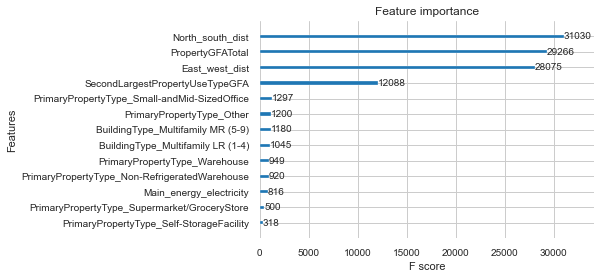

In [127]:
# Plot feature importance from best model 
xgb.plot_importance(xgb_reg_en_reduced_data_13f['model'])

In [128]:
# "North_south_dist" --> (built from) Latitude
# "East_west_dist" --> (built from) Longitude

selected_features_energy_target = ['Latitude',
                                   'Longitude',
                                   'PropertyGFATotal',
                                   'BuildingType',
                                   'PrimaryPropertyType',
                                   'SecondLargestPropertyUseTypeGFA',
                                   'Main_energy_electricity'] # Critical variable

print(f"Total of variables required : {len(selected_features_energy_target)}")

Total of variables required : 7


#### 2.2 - Selected features ( target : 'TotalGHGEmissions' ) <a class="anchor" id="fourth_2_2"></a>

In [129]:
rfr_em_mif_13_labels

['PropertyGFATotal',
 'Main_energy_electricity',
 'North_south_dist',
 'East_west_dist',
 'BuildingType_Multifamily LR (1-4)',
 'SecondLargestPropertyUseTypeGFA',
 'PrimaryPropertyType_Supermarket/GroceryStore',
 'BuildingType_Multifamily MR (5-9)',
 'PrimaryPropertyType_Other',
 'PrimaryPropertyType_Self-StorageFacility',
 'OldBuilding',
 'PrimaryPropertyType_Non-RefrigeratedWarehouse',
 'PrimaryPropertyType_Warehouse']

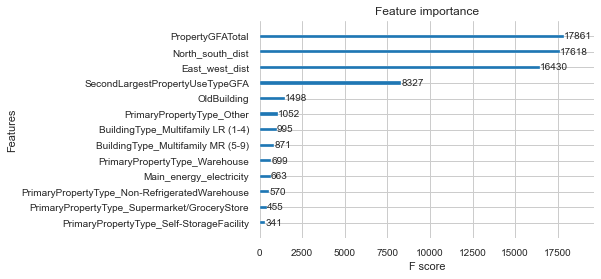

In [130]:
xgb.plot_importance(xgb_reg_em_reduced_data_13f['model'])

In [131]:
# "North_south_dist" --> (built from) Latitude
# "East_west_dist" --> (built from) Longitude
# "OldBuilding" --> (built from) YearBuilt

selected_features_emissions_target = ['Latitude',
                                      'Longitude',
                                      'YearBuilt',
                                      'PropertyGFATotal',
                                      'BuildingType',
                                      'PrimaryPropertyType',
                                      'SecondLargestPropertyUseTypeGFA',
                                      'Main_energy_electricity'] # Critical variable

print(f"Total of variables required : {len(selected_features_emissions_target)}")

Total of variables required : 8
